<a href="https://colab.research.google.com/github/lmoghimi/personal-processing/blob/main/post_beamline_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Run these first**

In [1]:
#@title Imports for JupyterLite
%pip install -q ipywidgets

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

import pandas as pd
import csv

import tkinter as tk
from tkinter import filedialog

from scipy.signal import find_peaks

# timestamps = ['primary-1', ]
shift = True            #
get_timestamps = True
#ntimestamps = 2 #for comparison between t0 and tf
ntimestamps = 125 #for all runs
#ntimestamps_depths
lw = 0.75 #linewidth
userdir = '/content/drive/Shareddrives/leoradm_group/NSLS-II_202406'
# userdir = '/nsls2/data/xpd-new/legacy/processed/xpdUser'
scriptdir = os.path.join(userdir, 'userScripts')

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
#@title Peak positions
wavelength = 0.1824 #angstrom

#ref_q_fe = [3.128, 5.419, 4.424, 6.995, 8.277, 6.257, 7.663]
#ref_q_fe = [3.128, 5.419, 4.424]
ref_q_fe = [3.128] #prominent isolated phase peak
#lincol_fe='tab:green' #iron
lincol_fe='tab:brown'

#ref_q_w = [2.905, 4.108, 2.516, 4.817, 6.495, 5.031, 7.115, 6.331, 8.715, 8.593, 7.547, 8.216, 5.810]
#ref_q_w = [2.905, 4.108, 2.516]
ref_q_w = [4.108] #prominent isolated phase peak
#lincol_w='tab:red' #wustite
lincol_w='tab:pink'

#ref_q_m = [2.4783, 2.5973, 4.2458, 3.8889, 2.1214, 2.9982, 5.7584, 3.6680, 1.2887, 4.9086]
#ref_q_m = [2.4783, 2.5973, 4.2458]
ref_q_m = [2.1214] #prominent isolated phase peak
#lincol_m='tab:purple' #magnetite
lincol_m='tab:green'

#ref_q_h = [2.4985, 2.3135, 3.7118, 4.3288, 3.41365, 4.2259, 1.6965, 2.8481, 4.8017, 3.92775, 4.9868, 5.6860, 5.5009, 5.9533, 6.5394]
#ref_q_h = [2.4985, 2.3135, 3.7118]
ref_q_h = [2.3135] #prominent isolated phase peak
#lincol_h='tab:orange' #hematite
lincol_h='tab:cyan'

#ref_q_ceo2 = [2.013, 2.324, 3.287, 3.854, 4.025, 4.648, 5.065, 5.197, 5.693, 6.038]
ref_q_ceo2 = [2.013]
lincol_ceo2 = 'tab:orange'

lincol_h_ore = 'tab:purple'

lincol_magh='tab:olive' #maghemite

lincol_qz = 'tab:gray' #quartz

#lincol_wf = 'tab:blue' #sets the line color for the waterfall series
#lincol_wf = 'navy'

In [4]:
#@title Inputs for peak finding
#range and prominence for peak finding for run#
I_fe_low, I_fe_up, prominence_fe = 790, 830, .03 #.1
I_w_low, I_w_up, prominence_w = 1080, 1120, .09 #.1 .05
I_m_low, I_m_up, prominence_m = 515, 540, .05 #.1
I_h_low, I_h_up, prominence_h = 575, 595, .05 #.03 #.1
I_ceo2_low, I_ceo2_up, prominence_ceo2 = 470, 510, .1
response = "n"
markersz = 2
lw = 2

# **Functions**

In [5]:
#@title foldername
def foldername(file_name):
    '''
    returns the run folder when given a file name
    '''
    parsename = file_name.split('-')[0].split('_')
    #print('parsename =', parsename)
    #print('last element=', parsename[-1])
    parsename.remove(parsename[-1])
    #print('result is', '_'.join(parsename))

    run_folder = '_'.join(parsename)
    print('run_folder =', run_folder)
    return run_folder

In [6]:
#@title get_rawdata
def get_rawdata(run_folder, file_name):
    '''
    Output: rawdata i.e. q and I
    '''
    run_path = os.path.join(userdir, 'tiff_base', run_folder, 'integration')
    print('run_path = ', run_path)
    file_path = os.path.join(run_path,file_name)
    print('file_path =', file_path)

    rawdata = np.loadtxt(file_path)
    print('rawdata has been loaded')
    return rawdata

In [7]:
#@title plot_vert_refs
def plot_vert_refs(axisss,q):
    #see where the peak range should be, for given input index
    axisss.axvline(x=q[I_fe_low], linestyle='solid', linewidth = lw_fp, color=lincol_fe)
    axisss.axvline(x=q[I_fe_up], linestyle='solid', linewidth = lw_fp, color=lincol_fe)
    axisss.axvline(x=q[I_w_low], linestyle='solid', linewidth = lw_fp, color=lincol_w)
    axisss.axvline(x=q[I_w_up], linestyle='solid', linewidth = lw_fp, color=lincol_w)
    axisss.axvline(x=q[I_m_low], linestyle='solid', linewidth = lw_fp, color=lincol_m)
    axisss.axvline(x=q[I_m_up], linestyle='solid', linewidth = lw_fp, color=lincol_m)
    axisss.axvline(x=q[I_h_low], linestyle='solid', linewidth = lw_fp, color=lincol_h)
    axisss.axvline(x=q[I_h_up], linestyle='solid', linewidth = lw_fp, color=lincol_h)
    axisss.axvline(x=q[I_ceo2_low], linestyle='solid', linewidth = lw_fp, color=lincol_ceo2)
    axisss.axvline(x=q[I_ceo2_up], linestyle='solid', linewidth = lw_fp, color=lincol_ceo2)

In [8]:
#@title plot_mult_refs()
def plot_mult_refs(axisss):
    ######### load multiple reference files, Yifan, 2024/4/12
    #ref_phases = ['Iron_2300200_q', 'Wuestite_9009766_q','Lab_magnetite_q','Lab_hematite_q','67p_Fe_ore_q']
    #color_ref_phases = [lincol_fe, lincol_w, lincol_m, lincol_h, lincol_h_ore]
    ref_phases = ['Iron_2300200_q', 'Wustite_q','Lab_magnetite_q','Lab_hematite_q','67p_Fe_ore_q','Ceria_q']
    color_ref_phases = [lincol_fe, lincol_w, lincol_m, lincol_h, lincol_h_ore, lincol_ceo2]
    ref_shift_y = -1
    for i_phase, ref_phase in enumerate(ref_phases):
        reffile = os.path.join(userdir, 'userScripts', 'xrd_profiles', ref_phase + '.txt')
        refdata = np.loadtxt(reffile)
        q_ref = refdata[:, 0]
        I_ref = refdata[:, 1]
        I_ref = I_ref - I_ref.min() #"baselining" the data
        I_ref = I_ref/(I_ref.max())  + ref_shift_y*(i_phase + 1) -5
        axisss.plot(q_ref, I_ref, label= ref_phase, linewidth= lw, color= color_ref_phases[i_phase])

In [9]:
#@title find_pk_phase
def find_pk_phase(lower,upper,I,prom):
    '''
    find the peak for a given phase
    I_phase[lower,upper] gives the signal in the range of interest. lower and upper are the indices for the lower and upper bounds, respectively
    output: set of val1 and val2 for this phase
    '''
    peaks, properties = find_peaks(I[lower:upper], prom)
    #print(peaks, properties)
    #print('Index of peak in x that satisfy all given conditions: ', peaks)
    #print('Peak height: ', properties['peak_heights'])

    if peaks.size > 0: #i.e. if the list isn't empty --> if a peak was found
        val1 = q[(lower + peaks)][0] #there should only be one peak identified by find_peaks if the proper range was selected, so selecting the first value of the array should really be the only value
        val2 = I[(lower + peaks)][0]
        #print('the phase peak is located at q = ', val1, ' with I = ', val2)
    else:
        #print('List is empty. No peaks found in the specified range')
        val1 = float('nan')
        val2 = 0 #set intensity equal to zero if no peak is found
    return val1, val2


# **Loading data**

In [ ]:
#@title Load and plot one scan
file_name = 'run126_references_20240624-071605_450af9_primary-1_mean_q.chi'
run_folder = foldername(file_name)
results = get_rawdata(run_folder, file_name)
q = results[:, 0]
I = results[:, 1]

## create figure object -- plotting setting ##
#figsize = (12, 6)
figsize = (10, 6)
fs = 18
fig, ax = plt.subplots(2, figsize=figsize, tight_layout=True)

ax[1].set_xlabel(r'$q  ({\AA}^{-1})$', fontsize=fs)
ax[1].set_yticks([])
ax[1].tick_params(labelsize=fs)
ax[1].set_xlim([-.25,11])

#ax.plot(q, I/I.max(), linewidth = lw)
ax[0].plot(q, I, linewidth = lw)
print('I.max() =',I.max())
lw_fp=1

#####################################################
ax[0].axhline(y=0, linestyle='dotted', linewidth = lw_fp, color='k')
ax[0].axhline(y=I.max(), linestyle='dotted', linewidth = lw_fp, color='k')
#plot_vert_refs()
ax[0].axvline(x=q[200], linestyle='dotted', linewidth = lw_fp, color='k')
ax[0].axvline(x=q[450], linestyle='dotted', linewidth = lw_fp, color='k')

ax[0].axvline(x=q[I_fe_low], linestyle='solid', linewidth = lw_fp, color=lincol_fe)
ax[0].axvline(x=q[I_fe_up], linestyle='solid', linewidth = lw_fp, color=lincol_fe)
ax[0].axvline(x=q[I_w_low], linestyle='solid', linewidth = lw_fp, color=lincol_w)
ax[0].axvline(x=q[I_w_up], linestyle='solid', linewidth = lw_fp, color=lincol_w)
ax[0].axvline(x=q[I_m_low], linestyle='solid', linewidth = lw_fp, color=lincol_m)
ax[0].axvline(x=q[I_m_up], linestyle='solid', linewidth = lw_fp, color=lincol_m)
ax[0].axvline(x=q[I_h_low], linestyle='solid', linewidth = lw_fp, color=lincol_h)
ax[0].axvline(x=q[I_h_up], linestyle='solid', linewidth = lw_fp, color=lincol_h)
ax[0].axvline(x=q[I_ceo2_low], linestyle='solid', linewidth = lw_fp, color=lincol_ceo2)
ax[0].axvline(x=q[I_ceo2_up], linestyle='solid', linewidth = lw_fp, color=lincol_ceo2)
#####################################################

plot_mult_refs(ax[1])

ax[1].legend(loc='center left', bbox_to_anchor=[1, 0.5])
ax[0].set_xlim([-.25,11])
#ax.set_ylim([-12,1])

ax[0].set_title(run_folder, fontsize=fs)
ax[0].set_xlim([-.25,11])
ax[0].set_xticks([])
ax[0].set_ylim([-.25,I.max()])
ax[0].set_ylabel(r'$I$', fontsize=fs)
ax[0].tick_params(labelsize=fs)
ax[0].plot(q, I, linewidth = lw,color='tab:gray')

In [ ]:
#@title Load in-situ or depth scan series
#doesn't use "run#" as an essential part of the code. instead, relies on an a common filename within a given file path
#depth file name example: run106_hematite_H2_blue_lowPower_20240623-204534_b2a369_ss_stg2_y_40,95mm_primary-1_mean_q
#filelist input: run106_hematite_H2_blue_lowPower_20240623-205741_85c755_ss_stg2_y_*
#in-situ file name example: run105_Ar_blue_Tcalib_20240623-200639_fc2f22_primary-1_mean_q.chi
#filelist input: run105_Ar_blue_Tcalib_20240623-200639_fc2f22_*

#give the waterfall plot for in-situ series or depth series?
data_series_type = ['in-situ','depth'] #0 or 1
response = data_series_type[0] #!#!#!#!#!#!#!#!#!# (this only affects the plot labeling)
print('response =', response)

run_folder = 'run105_Ar_blue_Tcalib' #!#!#!#!#!#!#!#!#!# in which "run" folder is the data located?
run_path = os.path.join(userdir, 'tiff_base', run_folder, 'integration')
print('run_path = ', run_path)

#which files to read?
###################### parsing the filename
#filelist = glob.glob(run_path + '/run106_hematite_H2_blue_lowPower_20240623-205741_85c755_ss_stg2_y_*') #the common file name amongst all the "before" depth scans
#filelist = glob.glob(run_path + '/run105_Ar_blue_Tcalib_20240623-200639_fc2f22_*') #!#!#!#!#!#!#!#!#!# the common file name amongst all the in-situ scans
filelist = glob.glob(run_path + '/run105_Ar_blue_Tcalib_20240623-200639_fc2f22_*')
# print(filelist)
filedict = {}

for filename in filelist:
    file_parse = os.path.basename(filename).split('_')
    if not ('tth' in file_parse):
        if ('ss' in file_parse or 'stg2' in file_parse): ###
            file_number = file_parse[-3]
            filedict[file_number] = filename
        elif not ('ss' in file_parse or 'stg2' in file_parse):
            file_number = file_parse[-3]
            filedict[file_number] = filename

#print('\n filedict =')
#print(filedict)
print('number of files: ', len(filedict))
#ntimestamps = 15 #!#!#!#!#!#!#!#!#!# change as needed
ntimestamps = len(filedict)

################# grab ntimestamps curves (equally spacing in time)
if get_timestamps:
    #timestamps = ['primary-%d'%k for k in np.linspace(1, len(filedict)-1, ntimestamps).astype(int)] #this prepares the list of files to plot in chronological order
    timestamps = ['primary-%d'%k for k in np.linspace(1, len(filedict), ntimestamps).astype(int)] #this organizes the list in chronological order ##@Yifan, shouldn't this be the correct line?
#print(timestamps)

raw_data_save_all = []
save_depth = []
#save_time_insitu = []

print('ntimestamps (entered) =', ntimestamps)
for iv, timestamp in enumerate(timestamps): #this section loads the selected files in chronological order, into the array raw_data_save_all
    timestamp_num = int(timestamp.split('-')[-1]) # convert timestamp string to number
    filename = filedict[timestamp]
    # print()
    #print('Loading file...', os.path.basename(filename))
    #print('Scan # ', timestamp_num)
    rawdata = np.loadtxt(filename) #each rawdata is [(#data, 2)], where 2 represents q and I columns. q = rawdata[:, 0], I = rawdata[:, 1]
    raw_data_save_all.append(rawdata) #stacks the array  #makes 3D array of 125, q and I for each run --> (nstimestamps, nt, 2)
    if response == 'depth':
        save_depth.append([timestamp_num, os.path.basename(filename).split('_')[-4]])

##### convert raw data_save_all into numpy array ######
raw_data_save_all = np.array(raw_data_save_all)
print('shape of raw_data_save_all array is: ', raw_data_save_all.shape)

#print(save_depth)
save_depth = np.array(save_depth)
print(save_depth)
print(save_depth.shape)

response = in-situ
run_path =  /content/drive/Shareddrives/leoradm_group/NSLS-II_202406/tiff_base/run105_Ar_blue_Tcalib/integration
number of files:  175
ntimestamps (entered) = 175
shape of raw_data_save_all array is:  (175, 3000, 2)
[]
(0,)


# **Plot raw XRD data**

In [ ]:
#@title Background subtraction (in progress)
#intermediate outputs: background's peak intensity within the non-background data, scaling ratio between background and non-background files' peak intensity, scaled up/down background for the subtraction
#should totally plot the intensity as a function of time for this background peak
'''
inputs: background peak, range of background's peak within the non-background
output: background-subtracted scan
'''
def backsubtr(file)
    background_ref = 'run126_references_20240624-071605_450af9_primary-1_mean_q.chi'
    prominence =
    peaks, properties = find_peaks(1:1.9, )

#suggested input: Chamber_background_450af9_q.txt

In [ ]:
#@title Save frames to generate movie
from time import localtime, strftime

#### inputs #####
print('number of files = ', raw_data_save_all.shape[0])
now = strftime("%Y-%m-%d_%H%M%S", localtime()) #note: this is expressed in UTC time
frame_folder = run_folder + '_' + now #!#!#!#!#!#!#! input desired folder name for the frames

#### plot inputs  ####
figsize = (10, 6)
fs = 18
fig, ax = plt.subplots(2, figsize=figsize, tight_layout=True)
ax[1].set_xlabel(r'$q  ({\AA}^{-1})$', fontsize=fs)
ax[1].set_yticks([])
ax[1].tick_params(labelsize=fs)
ax[1].set_xlim([-.25,11])

#### generating frames ####
#print(timestamps) #timestamps and raw_data_save_all.shape should be equivalent ways of defining the number of frames for the movie!
# print(timestamps[0], timestamps[174])
frames = np.linspace(1, raw_data_save_all.shape[0], raw_data_save_all.shape[0]) #generate vector of n values from 1 to n
frames = [int(x) for x in frames]
print('frames=',frames)

Imax = raw_data_save_all[:,:,1].max() #finding the max intensity for the dataset. this is a reasonable since the number of scans (usually <250) is relatively small to the highest intensity observed throughout the full experiment
print('Imax =',Imax)

# ref_phases = ['Iron_2300200_q', 'Wustite_q','Lab_magnetite_q','Lab_hematite_q','67p_Fe_ore_q','Ceria_q','Chamber_background_450af9_q'] #add fayalite
# color_ref_phases = [lincol_fe, lincol_w, lincol_m, lincol_h, lincol_h_ore, lincol_ceo2,'tab:gray']
ref_phases = ['Iron_2300200_q', 'Wustite_q','Lab_magnetite_q','Lab_hematite_q','Ceria_q','Chamber_background_450af9_q'] #add fayalite
color_ref_phases = [lincol_fe, lincol_w, lincol_m, lincol_h, lincol_ceo2,'tab:gray']

ref_shift_y = -1
for i_phase, ref_phase in enumerate(ref_phases):
    reffile = os.path.join(userdir, 'userScripts', 'xrd_profiles', ref_phase + '.txt')
    refdata = np.loadtxt(reffile)
    q_ref = refdata[:, 0]
    I_ref = refdata[:, 1]
    #here I will write background-subtracted raw data, then baseline after

    I_ref = I_ref - I_ref.min() #"baselining" the data
    I_ref = I_ref/(I_ref.max())  + ref_shift_y*(i_phase + 1) -5
    ax[1].plot(q_ref, I_ref, label= ref_phase, linewidth= lw, color= color_ref_phases[i_phase])
plt.legend(loc='upper right')

for frame in frames:
    rawdata = raw_data_save_all[frame-1, :, :]
    q = rawdata[:, 0]
    I = rawdata[:, 1]

    #print('Saving frame...!',frame,'/',raw_data_save_all.shape[0])
    fname_typ = frame_folder + '_' + str(frame) +'.png'
    save_loc = os.path.join(userdir, 'userAnalysis', 'movies_insitu', frame_folder)
    # delete????? if not os.path.isdir(save_loc):

    #fig, ax = plt.subplots(figsize=figsize, tight_layout=True)
    ax[0].set_title(run_folder +'_frame#' + str(frame), fontsize=fs)
    ax[0].set_xlim([-.25,11])
    ax[0].set_xticks([])
    ax[0].set_ylim([-.25,Imax])
    ax[0].set_ylabel(r'$I$', fontsize=fs)
    ax[0].tick_params(labelsize=fs)
    my_data = ax[0].plot(q, I, linewidth = lw,color='tab:gray')
    os.makedirs(save_loc, exist_ok=True)

    plt.savefig(os.path.join(save_loc, fname_typ))
    ax[0].clear() #my_data.remove() # del my_data

print('Saved all frames to ',save_loc)

In [ ]:
#@title Generate movie
#reference: https://stackoverflow.com/questions/44947505/how-to-make-a-movie-out-of-images-in-python
#https://stackoverflow.com/questions/73609006/how-to-create-a-video-out-of-frames-without-saving-it-to-disk-using-python

import cv2
import os
image_folder = save_loc
video_name = frame_folder + '.mp4'
print('video_name:',video_name)

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
print('images:',images)
print('# of images:',len(images))

frame1 = cv2.imread(os.path.join(image_folder, images[0]))
plt.imshow(frame1)
#print('frame1 read from file located here:',os.path.join(image_folder, images[0]))
height, width, layers = frame1.shape
#print('h, w, l =',frame1.shape)

#video = cv2.VideoWriter(video_name, 0, 1, (width,height))
fourcc = cv2.VideoWriter_fourcc(*'mp4v') #*'XVID'
video = cv2.VideoWriter(video_name, fourcc, 3, (width, height),1) #(width, height)

for image in images:
    #video.write(cv2.imread(os.path.join(image_folder, image)))
    #temp = cv2.imread(os.path.join('/content/drive/Shareddrives/leoradm_group/NSLS-II_202406/userAnalysis/movies_insitu', image))
    temp = cv2.imread(os.path.join(image_folder, image))
    video.write(temp)

cv2.destroyAllWindows()
video.release()

#print('image_folder (where we want to write the video):',image_folder)
print('Done generating movie! Remember to download from Colab!')

In [ ]:
#@title Waterfall and finding background peak vs time

## create figure object -- plotting setting ##
#figsize = (12, 6)
figsize = (10, 6)
fs = 18
thisfs = 10
fig, ax = plt.subplots(figsize=figsize, tight_layout=True)

ax.set_xlabel(r'$q  ({\AA}^{-1})$', fontsize=fs)
ax.set_ylabel(r'$I$', fontsize=fs)
ax.set_title(run_folder + ' ' + response + ' series', fontsize=fs)
ax.tick_params(labelsize=fs)

##plot display for markers and reference lines
lw_fp = 0.025 #linewidth for find_peaks range
markersz = .5 #define marker size for results of find_peaks
#markersh = 'x' #define marker shape
markersh = 'o'
marcol_h = 'b'
mark_dist = 0 #marker vertical distance from peak

mark_dist = 0 #marker vertical distance from peak

plot_mult_refs(ax)
ax.set_xlim([-.5,11])
## here we want to define 8 sets of inputs: 4 scrollbars to define the range for each phase peak, 4 inputs for the prominence of each phase peak

################ plotting selected timestamps and finding peaks ########################################################
num_of_lines = len(timestamps)
lincol_gradient = iter(cm.copper(np.linspace(0,1,num_of_lines))) #Wistia, copper, and autumn are nice gradients
counting = 0
find_peak_outputs = []
for iv, timestamp in enumerate(timestamps):
    #print(iv)
    timestamp_num = int(timestamp.split('-')[-1]) # convert timestamp string to number
    filename = filedict[timestamp]
    rawdata = raw_data_save_all[iv, :, :]
    q = rawdata[:, 0]
    I = rawdata[:, 1]
    #I = I - I.min() #"baselining" the data

    if timestamp == 'primary-1':
      print('This is the first file')
      #I0 = I
      I0 = I.copy() #fix I0!!!!!!!!!!!!!!!!!!!!!!!!!
      I_treated = I0 #/I0.max()

    else:
      #print('not the first file...')
      #I_treated = I/I0
      I_treated = I #I/I0.max()
      #I = I + iv * 5 #only for visualizing, not for peak finding

    ###### plot waterfall data ########################################
    c=next(lincol_gradient)
    #ax.plot(q, I, color = c, linewidth = lw)
    wf_shift = iv*100

    I_plot = I_treated + wf_shift
    ax.plot(q, I_plot, color = c, linewidth = lw)
    if response == 'in-situ':
        line_label = timestamp
    elif response == 'depth':
        prim_num = int(timestamp.split('-')[1]) #return the "primary-#" for this scan
        #print(save_depth[prim_num -1,1])
        line_label = str(save_depth[prim_num -1,1]) #return the corresponding depth for this scan
        line_label = line_label.split('mm')[0] #remove mm from the label
    else:
        print('something weird is going on')
    ax.text(q[0]-.2, I_plot[0], line_label, ha='right', va='center', fontsize='8')
    ax.set_yticklabels('')

    counting = counting + 1

    ####### find peaks ######################################################
    ax.axvline(x=q[I_h_low], linestyle='solid', linewidth = lw_fp, color=lincol_h)
    ax.axvline(x=q[I_h_up], linestyle='solid', linewidth = lw_fp, color=lincol_h)
    I_bkgd_low = 295
    I_bkgd_up = 390
    ax.axvline(x=q[I_bkgd_low], linestyle='solid', linewidth = lw_fp)
    ax.axvline(x=q[I_bkgd_up], linestyle='solid', linewidth = lw_fp)



    I_h = I_treated[I_h_low:I_h_up]
    I_bkgd = I_treated[I_bkgd_low:I_bkgd_up]

    #num_phases = ['fe', 'w', 'm', 'h']
    num_phases = ['fe', 'w', 'm', 'h', 'ceo2','bkgd']
    prominence_h = 50
    for iii in num_phases: #repeat this process for each phase
      ############for hematite#############################
      if iii == num_phases[3]:
        result = find_pk_phase(I_h_low,I_h_up,I_treated,prominence_h)
        val1_h = result[0]
        val2_h = result[1]
        ax.plot(val1_h, val2_h + wf_shift + mark_dist, color = marcol_h, marker=markersh, markersize = markersz)
      ############for background#############################
      if iii == num_phases[5]:
        #result = find_pk_phase(I_bkgd_low,I_bkgd_up,I_treated,prominence_h)
        lizzy = I_treated[I_bkgd_low:I_bkgd_up].tolist()
        #print('lizzy',lizzy)
        max_val = I_treated[I_bkgd_low:I_bkgd_up].max()
        #print('max_val=',max_val)
        #print('index=', lizzy.index(max_val)+I_bkgd_low)
        val1_bkgd = q[I_bkgd_low+lizzy.index(max_val)]  #result[0]
        val2_bkgd =  max_val #result[1]
        ax.plot(val1_bkgd, val2_bkgd + wf_shift + mark_dist, color = 'm', marker=markersh, markersize = markersz)

    #set the values here for this one timestamp
    item = {'Scan#': timestamp_num,
            'H': [val1_h, val2_h],
            'Bkgd': [val1_bkgd, val2_bkgd],
            }
    find_peak_outputs.append(item)

#print('find_peak_outputs = ', find_peak_outputs) #now that we've finished "for iv, timestamp in enumerate(timestamps)"
ax.legend(loc='center left', bbox_to_anchor=[1, 0.5])


###### plotting results vs time ##################################################
x = []
y_h = []
y_bkgd = []
'''
print("find_peak_outputs = ", find_peak_outputs)
print('timestamps = ', timestamps)
print('ntimestamps = ', ntimestamps)
print()
'''
for i, timestamp in enumerate(timestamps):
  timestamp_num = int(timestamp.split('-')[-1]) # convert timestamp string to number
  #print('timestamp_num = ', timestamp_num)
  index_request = i
  #print('index is =', index_request)
  if index_request > ntimestamps: #once we've gone through the full list of timestamps, break the for loop
    break
  else:
    scan = find_peak_outputs[index_request]['Scan#']
    inten_h = find_peak_outputs[index_request]['H'][1] #second value in the array gives intensity
    inten_bkgd = find_peak_outputs[index_request]['Bkgd'][1]
    x.append(scan)
    y_h.append(inten_h)
    y_bkgd.append(inten_bkgd)

x=np.array(x) #convereting lists to arrays
y_h=np.array(y_h)
y_bkgd=np.array(y_bkgd)

markersz1 = 40
fig, axx = plt.subplots(figsize=(6,6), tight_layout=True)
axx.set_xlim(0, (ntimestamps))
axx.scatter(x, y_h, color = lincol_h, marker='.', s=markersz1, label = 'H')
axx.plot(x, y_h, linewidth = lw, color = lincol_h)
axx.scatter(x, y_bkgd, color = 'm', marker='.', s=markersz1, label = 'Bkgd')
axx.plot(x, y_bkgd, linewidth = lw, color = 'm')




plt.legend(loc='upper right')
# axx.set_xlabel('Scan #', fontsize=thisfs)
axx.set_xlabel('Time (sec)', fontsize=thisfs)
axx.set_ylabel('Intensity (a.u.)', fontsize=thisfs)
axx.tick_params(axis='x', labelsize=thisfs)
axx.tick_params(axis='y', labelsize=thisfs)
plottit = 'Peak intensity vs. time: ' + run_folder.split('_')[0]
axx.set_title(plottit, fontsize=thisfs)
plt.show()

In [ ]:
#@title Waterfall plot and results of findpeaks (don't edit unless necessary)

## create figure object -- plotting setting ##
#figsize = (12, 6)
figsize = (10, 6)
fs = 18
fig, ax = plt.subplots(figsize=figsize, tight_layout=True)

ax.set_xlabel(r'$q  ({\AA}^{-1})$', fontsize=fs)
ax.set_ylabel(r'$I$', fontsize=fs)
ax.set_title(run_folder + ' ' + response + ' series', fontsize=fs)
ax.tick_params(labelsize=fs)

##plot display for markers and reference lines
lw_fp = 0.025 #linewidth for find_peaks range
markersz = .5 #define marker size for results of find_peaks
#markersh = 'x' #define marker shape
markersh = 'o'
marcol_fe = 'b'
marcol_h = 'b'
marcol_w = 'b'
marcol_m = 'b'
mark_dist = 0 #marker vertical distance from peak

plot_mult_refs(ax)
ax.set_xlim([-.5,11])
## here we want to define 8 sets of inputs: 4 scrollbars to define the range for each phase peak, 4 inputs for the prominence of each phase peak


################# plotting setting #####################################################################################
# figsize = (10, 6)
# fs = 18
# fig, ax = plt.subplots(figsize=figsize, tight_layout=True) #this is key for "hold on"!!!!
# ax.clear()

################ plotting selected timestamps and finding peaks ########################################################
num_of_lines = len(timestamps)
lincol_gradient = iter(cm.copper(np.linspace(0,1,num_of_lines))) #Wistia, copper, and autumn are nice gradients
counting = 0
find_peak_outputs = []
for iv, timestamp in enumerate(timestamps):
    #print(iv)
    timestamp_num = int(timestamp.split('-')[-1]) # convert timestamp string to number
    filename = filedict[timestamp]
    rawdata = raw_data_save_all[iv, :, :]
    q = rawdata[:, 0]
    I = rawdata[:, 1]
    I = I - I.min() #"baselining" the data

    if timestamp == 'primary-1':
      print('This is the first file')
      #I0 = I
      I0 = I.copy() #fix I0!!!!!!!!!!!!!!!!!!!!!!!!!
      I_treated = I0/I0.max()
    # '''
    # if timestamp == 'primary-1': #for run 52, need to have 125 files
    #   print('This is the first file')
    #   I_treated = I/I.max()
    # elif timestamp == 'primary-2': #for run 52, need to have 125 files
    #   print('This is the second file')
    #   #I0 = I
    #   I0 = I.copy() #fix I0!!!!!!!!!!!!!!!!!!!!!!!!!
    #   I_treated = I0/I0.max()
    # '''
    else:
      #print('not the first file...')
      #I_treated = I/I0
      I_treated = I/I0.max()
      #I = I + iv * 5 #only for visualizing, not for peak finding

    ###### plot waterfall data ########################################
    c=next(lincol_gradient)
    #ax.plot(q, I, color = c, linewidth = lw)
    wf_shift = iv*2

    I_plot = I_treated + wf_shift
    ax.plot(q, I_plot, color = c, linewidth = lw)
    if response == 'in-situ':
        line_label = timestamp
    elif response == 'depth':
        prim_num = int(timestamp.split('-')[1]) #return the "primary-#" for this scan
        #print(save_depth[prim_num -1,1])
        line_label = str(save_depth[prim_num -1,1]) #return the corresponding depth for this scan
        line_label = line_label.split('mm')[0] #remove mm from the label
    else:
        print('something weird is going on')
    ax.text(q[0]-.2, I_plot[0], line_label, ha='right', va='center', fontsize='8')
    ax.set_yticklabels('')

    counting = counting + 1

    ####### find peaks ######################################################

    #see where the peak range should be, for given input index
    ax.axvline(x=q[I_fe_low], linestyle='solid', linewidth = lw_fp, color=lincol_fe)
    ax.axvline(x=q[I_fe_up], linestyle='solid', linewidth = lw_fp, color=lincol_fe)
    ax.axvline(x=q[I_w_low], linestyle='solid', linewidth = lw_fp, color=lincol_w)
    ax.axvline(x=q[I_w_up], linestyle='solid', linewidth = lw_fp, color=lincol_w)
    ax.axvline(x=q[I_m_low], linestyle='solid', linewidth = lw_fp, color=lincol_m)
    ax.axvline(x=q[I_m_up], linestyle='solid', linewidth = lw_fp, color=lincol_m)
    ax.axvline(x=q[I_h_low], linestyle='solid', linewidth = lw_fp, color=lincol_h)
    ax.axvline(x=q[I_h_up], linestyle='solid', linewidth = lw_fp, color=lincol_h)
    ax.axvline(x=q[I_ceo2_low], linestyle='solid', linewidth = lw_fp, color=lincol_ceo2)
    ax.axvline(x=q[I_ceo2_up], linestyle='solid', linewidth = lw_fp, color=lincol_ceo2)

    #ax.axhline(y=prominence_fe, linestyle='solid', linewidth = .1, color=lincol_fe)
    ##ax.axhline(y=prominence_w, linestyle='solid', linewidth = .1, color=lincol_w)
    ##ax.axhline(y=prominence_m, linestyle='solid', linewidth = .1, color=lincol_m)
    ##ax.axhline(y=prominence_h, linestyle='solid', linewidth = .1, color=lincol_h)

    I_fe = I_treated[I_fe_low:I_fe_up] #define index of range within q to find peaks
    I_w = I_treated[I_w_low:I_w_up]
    I_m = I_treated[I_m_low:I_m_up]
    I_h = I_treated[I_h_low:I_h_up]
    I_ceo2 = I_treated[I_ceo2_low:I_ceo2_up]

    #num_phases = ['fe', 'w', 'm', 'h']
    num_phases = ['fe', 'w', 'm', 'h', 'ceo2']
    for iii in num_phases: #repeat this process for each phase
      #print('iii = ', iii)
      ############for iron#############################
      if iii == num_phases[0]:
        result = find_pk_phase(I_fe_low,I_fe_up,I_treated,prominence_fe)
        val1_fe = result[0]
        val2_fe = result[1]
        ax.plot(val1_fe, val2_fe + wf_shift + mark_dist, color = marcol_fe, marker=markersh, markersize = markersz)
      ############for wustite#############################
      if iii == num_phases[1]:
        result = find_pk_phase(I_w_low,I_w_up,I_treated,prominence_w)
        val1_w = result[0]
        val2_w = result[1]
        ax.plot(val1_w, val2_w + wf_shift + mark_dist, color = marcol_w, marker=markersh, markersize = markersz)
      ############for magnetite#############################
      if iii == num_phases[2]:
        result = find_pk_phase(I_m_low,I_m_up,I_treated,prominence_m)
        val1_m = result[0]
        val2_m = result[1]
        ax.plot(val1_m, val2_m + wf_shift + mark_dist, color = marcol_m, marker=markersh, markersize = markersz)
      ############for hematite#############################
      if iii == num_phases[3]:
        result = find_pk_phase(I_h_low,I_h_up,I_treated,prominence_h)
        val1_h = result[0]
        val2_h = result[1]
        ax.plot(val1_h, val2_h + wf_shift + mark_dist, color = marcol_h, marker=markersh, markersize = markersz)
      ############for ceria#############################
      if iii == num_phases[4]:
        result = find_pk_phase(I_ceo2_low,I_ceo2_up,I_treated,prominence_ceo2)
        val1_ceo2 = result[0]
        val2_ceo2 = result[1]
        ax.plot(val1_ceo2, val2_ceo2 + wf_shift + mark_dist, color = marcol_m, marker=markersh, markersize = markersz)

    #set the values here for this one timestamp
    item = {'Scan#': timestamp_num,
            'Fe': [val1_fe, val2_fe],
            'H': [val1_h, val2_h],
            'W': [val1_w, val2_w],
            'M': [val1_m, val2_m],
            'CeO2': [val1_ceo2, val2_ceo2]
            }
    find_peak_outputs.append(item)

#print('find_peak_outputs = ', find_peak_outputs) #now that we've finished "for iv, timestamp in enumerate(timestamps)"
ax.legend(loc='center left', bbox_to_anchor=[1, 0.5])

# **Processed plots**

In [ ]:
#@title INPUTS to link laser log and pyrometer
#DAQ's t=0, in-situ series parameters, pyrometer, laser/PS, index of power supply that corresponds to DAQ's t=0
####################### inputs ###################################
#input farther down the run # --> run60
t_laser_log_start = '8:06:39 PM'
t_laser_sampling = 1 #!#!#!#!#!#!#!#!#!#

index_start = 0 #!#!#!#!#!#!#!#!#!#

#index_start = 5 #6 sec difference → 6 sec / 1.2 sec/rec = rec:5

In [98]:
#@title process_pyrom()
#NOTE: Timestamp and datetime are two formats for expressing time and have their own methods. they are not compatible
def process_pyrom(fp):
    '''
    Reads the pyrometer data for a given input file and expresses data points relative to t0
    '''
    pyrom_data = pd.read_excel(fp)
    y_axis_pyrom = pyrom_data['eurotherm_temperature']
    x_axis_pyrom = []
    for i in pyrom_data['time']: #data is natively in the Timestamp format
        if i == pyrom_data['time'][0]:
            #print('this is the pyrometer start, unformatted:',i,'-- it is in UTC')
            start = i.tz_localize('UTC') #this is the starting time
            #start = i.tz_localize('America/New_York')
            ##start = i.to_datetime64()
            start_datetime_new_york = start.tz_convert('America/New_York') #Timestamp format. converting to eastern daylight time
            start_datetime_new_york = start_datetime_new_york.strftime("%m-%d-%Y %H:%M:%S")
            dt_sec = 0
        elif i == pyrom_data['time'][len(pyrom_data['time'])-1]:
            end = i.tz_localize('UTC')
            #end = i.tz_localize('America/New_York')
            ##end = i.to_datetime64()
            end_datetime_new_york = end.tz_convert('America/New_York')
            end_datetime_new_york = end_datetime_new_york.strftime("%m-%d-%Y %H:%M:%S")
        else:
            dt2 = i.tz_localize('UTC')
            #dt2 = i.tz_localize('America/New_York')
            ##dt2 = i.to_datetime64()
            dt = dt2 - start
            dt_sec = dt / np.timedelta64(1, 's')
            #print(dt_sec)
        x_axis_pyrom.append(dt_sec)
        #print('dt =', dt)
    # print('type=', type(dt))
    # print('type=', type(dt_sec))
    print('Pyrometer start time:', start_datetime_new_york,' EDT (military)')
    #print('Pyrometer end time:', end_datetime_new_york,' EDT (military)') #NOTE: this is not always accurate, due to mis-saving in the file

    return x_axis_pyrom, y_axis_pyrom, start_datetime_new_york

In [96]:
#@title process_laserlog()
def process_laserlog(fp):
    '''
    Reads the laser log data for a given input file and expresses data points relative to its t0
    '''
    laser_log_data = []
    with open(fp, mode = 'r') as file:
        csvFile = csv.DictReader(file)
        for lines in csvFile:
            #print(lines)
            laser_log_data.append(lines) #extract data from the file for python treatment

    #print(laser_log_data[1])
    lt_pt1 = laser_log_data[1]['FileType:PSCS_Data_Log'].split(':')[1] #this gives the date
    lt = str(laser_log_data[1][None]) #laser log start time + year
    lt = lt.replace("['", "")
    lt_pt2 = lt.replace("']", "")
    lt = lt_pt1 + lt_pt2
    #print(lt)
    st = laser_log_data[2]['FileType:PSCS_Data_Log'].split(':')[-1]
    st = st.replace('S', '') #sampling time

    print('The log began recording at',lt,'and the sampling time is',st,'sec')


    recnum = []
    volt = []
    current = []
    count = 0
    for lines in laser_log_data:
        if count >= 4:
            recnum.append(int(laser_log_data[count]['FileType:PSCS_Data_Log'].split(':')[-1]))
            volt.append(int(laser_log_data[count][None][0]) / 1000) #in V
            current.append(int(laser_log_data[count][None][1]) / 1000) #in A
        # elif count < 4:
        #     print('no its not')
        count = count + 1
    print()
    #print('recnum = ', recnum)
    #print('volt = ', volt)
    #print('current = ', current)
    power = np.multiply(volt, current)
    #print('power = ', power)

    return st, lt, recnum, power

fp =  /content/drive/Shareddrives/leoradm_group/NSLS-II_202406/tiff_base/sample_56_20240622_210808.xlsx
Pyrometer start time: 06-22-2024 21:04:37  EDT (military)
x_max = 209.393


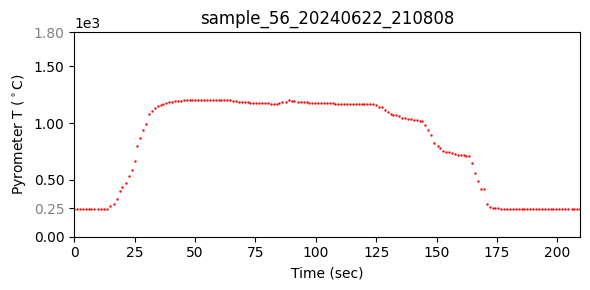

fp = /content/drive/Shareddrives/leoradm_group/NSLS-II_202406/june_laser_programs_and_logs/LOG-Jun.22.2024-09.08.21-run53.csv
The log began recording at Jun 22 2024 9:04:35 PM and the sampling time is 1 sec

x_axis =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 1

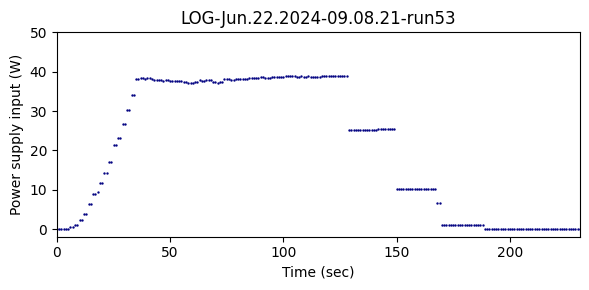

In [102]:
#@title Temperature and laser plots
#revised 9/6/24 - 9/8/24
fn_pyrom = 'sample_56_20240622_210808' #!#!#!#!#!#!#!#!#!#
#fn_pyrom = 'sample_127_20240624_045017'

fn_laser = 'LOG-Jun.22.2024-09.08.21-run53' #!#!#!#!#!#!#!#!#!#
#fn_laser = 'LOG-Jun.24.2024-04.57.56-122'

#################### pyrometer #####################################
#userdir = '/content/drive/Shareddrives/leoradm_group/NSLS-II_202406'
path = os.path.join(userdir, 'tiff_base')
#print('path = ',path)
fp = os.path.join(path, fn_pyrom + '.xlsx')
print('fp = ',fp)
result = process_pyrom(fp)

figsize = (6, 3)
fs = 18
fig, ax = plt.subplots(figsize=figsize, tight_layout=True)
ax.set_ylim(0, 1800)
ax.set_yticks([0, 250, 500, 1000, 1500, 1800])
ax.get_yticklabels()[1].set_color("gray") #changing the color for 248C
ax.get_yticklabels()[5].set_color("gray") #changing the color for 1800C

plt.scatter(result[0], result[1], marker = '.', s = markersz, c = 'r')
x_max = np.array(result[0], dtype='float32').max()
print('x_max =', x_max)
ax.set_xlim(0, x_max)

plt.ylabel("Pyrometer T ($^\circ$C)")
plt.xlabel("Time (sec)")
plt.title(fn_pyrom)

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()

##################################################################################
######################### laser log ###########################################
path = os.path.join(userdir, 'june_laser_programs_and_logs')
#print('path = ',path)
fp = os.path.join(path, fn_laser + '.csv')
print('fp =', fp)
result = process_laserlog(fp)
st = result[0]
lt = result[1]
recnum = result[2]
power = result[3]

x_axis_laser = [i * int(st) for i in recnum]
y_axis_laser = power
x_lim = max(np.array(x_axis_laser))
print('x_axis = ', x_axis_laser)


figsize = (6, 3)
fs = 18
fig, ax = plt.subplots(figsize=figsize, tight_layout=True)


#txt = 'The log began recording at ' + lt + ' with ' + st +' sec sampling \n t = 0 in the plot above is '+ t_xrd_start
plt.scatter(x_axis_laser, y_axis_laser, marker = '.', s = markersz, c = 'navy')
plt.ylabel("Power supply input (W)")
plt.xlabel("Time (sec)")
plt.title(fn_laser)
#plt.figtext(0.5, -.125, txt, wrap=True, horizontalalignment='center', fontsize=10)
ax.set_xlim(0, x_lim)
ax.set_yticks([0, 10, 20, 30, 40, 50])

##################################################################################

In [ ]:
#test cell


fp =  /content/drive/Shareddrives/leoradm_group/NSLS-II_202406/tiff_base/sample_56_20240622_210808.xlsx
Pyrometer start time: 06-22-2024 21:04:37  EDT (military)
fp =  /content/drive/Shareddrives/leoradm_group/NSLS-II_202406/june_laser_programs_and_logs/LOG-Jun.22.2024-09.08.21-run53.csv
The log began recording at Jun 22 2024 9:04:35 PM and the sampling time is 1 sec

t_laser_sampling 1
The laser log started recording first
index_offset_rounded: 2


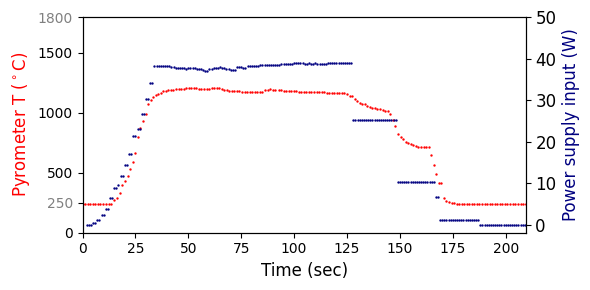

In [101]:
#@title Combined pyrometer and laser plots. t0 is set by the pyrometer (don't edit!!!)
###find which laser index matches the PYROMETER's t0.
import math
fn_pyrom = 'sample_56_20240622_210808' #!#!#!#!#!#!#!#!#!#
path = os.path.join(userdir, 'tiff_base')
fp = os.path.join(path, fn_pyrom + '.xlsx')
print('fp = ',fp)
result_pyrom = process_pyrom(fp)
start_pyrom = result_pyrom[2] #pyrometer's t0
timestamp_start_pyrom = pd.Timestamp(start_pyrom, tz='America/New_York') #setting the format to Timestamp, from a string
#end_pyrom =
x_max = np.array(result_pyrom[0], dtype='float32').max()
x_axis_pyrom = result_pyrom[0]
y_axis_pyrom = result_pyrom[1]

fn_laser = 'LOG-Jun.22.2024-09.08.21-run53' #!#!#!#!#!#!#!#!#!#
path = os.path.join(userdir, 'june_laser_programs_and_logs')
fp = os.path.join(path, fn_laser + '.csv')
print('fp = ',fp)
result_laser = process_laserlog(fp)
string_start_laser = lt
timestamp_start_laser = pd.Timestamp(string_start_laser, tz='America/New_York') #laser log's t0 (military time, matching the timezone we recorded in)
t_laser_sampling = int(result_laser[0]) #seconds per rec:index
print('t_laser_sampling', t_laser_sampling)
recnum = result_laser[2]
power = result_laser[3]

if timestamp_start_laser < timestamp_start_pyrom:
    print('The laser log started recording first')
    deltat0 = timestamp_start_pyrom - timestamp_start_laser
    deltat0_sec = deltat0 / np.timedelta64(1, 's')
    #print('deltat0_sec =',deltat0_sec)
    index_offset_t0 = deltat0_sec / t_laser_sampling #finds the laser rec:index that corresponds to the pyrometer's t0.
    index_offset_t0_rounded = math.ceil(index_offset_t0) #if the index is a non-integer, then plot the first index AFTER the pyrometer's t0
    print('index_offset_rounded:',index_offset_t0_rounded)

    #don't need to find the index that corresponds to t_final_x_ray, since we'll just cut the plotting off at the pyrometer's x_max
    y_laser = power[1+index_offset_t0_rounded : len(recnum)-1]

    start = 0
    step = t_laser_sampling
    num = len(y_laser)
    x_laser = index_offset_t0 + np.arange(0, num) * step #expressing laser data points in time, where t0 is set by the pyrometer

elif timestamp_start_pyrom < timestamp_start_laser:
    print('The pyrometer started recording first')
    print('there is no process for handling this yet. I need to write this')
    #divide this delta t0 by the sampling rate of the laser to get the laser rec:index that corresponds to the pyrometer's t0.
    deltat0 = timestamp_start_laser - timestamp_start_pyrom
    deltat0_sec = deltat0 / np.timedelta64(1, 's')
    index_offset_t0 = deltat0_sec / t_laser_sampling

    y_laser = power
    start = 0
    step = t_laser_sampling
    num = len(y_laser)
    x_laser = index_offset_t0 + np.arange(0, num) * step

    print('I have yet to test that this cell works as intended. But it should work. Need to find an experiment that fits this though.')

######################## plotting the combined figure #######################
figsize = (6, 3)
fs = 12
col_pyrom = 'r'
col_laser = 'navy'
fig, ax1 = plt.subplots(figsize=figsize, tight_layout=True)
ax1.set_ylim(0, 1800)
ax1.set_yticks([0, 250, 500, 1000, 1500, 1800])
ax1.get_yticklabels()[1].set_color("gray") #changing the color for 248C
ax1.get_yticklabels()[5].set_color("gray") #changing the color for 1800C

ax1.scatter(x_axis_pyrom, y_axis_pyrom, marker = '.', s = markersz, c = col_pyrom) #pyrometer
ax1.set_xlim(0, x_max)
ax1.set_ylabel("Pyrometer T ($^\circ$C)", fontsize=fs, color=col_pyrom)
ax1.set_xlabel("Time (sec)", fontsize=fs)
#plt.title(fn_pyrom)

ax2 = ax1.twinx()
ax2.scatter(x_laser, y_laser, marker = '.', s = markersz, c = col_laser) #laser log
ax2.set_ylabel('Power supply input (W)', fontsize=fs, color=col_laser)
ax2.set_yticks([0, 10, 20, 30, 40, 50])
ax2.tick_params(axis='y', labelsize=fs)

#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()

max T_pyrom = 1154
max T_C = 1958.466308976374


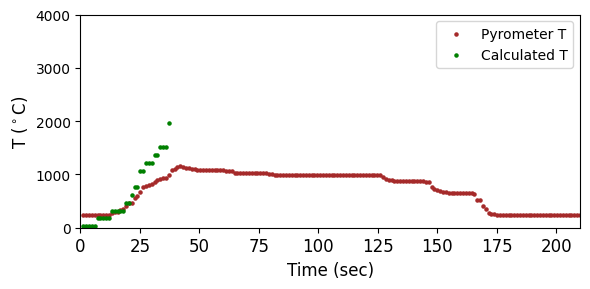

In [ ]:
#@title Calculated T (don't edit unless necessary)
#run the intensity vs time section first, to calculate the temperature from ceria

col_pyrom = 'brown'
col_calcT = 'green'
markersz2 = 20

# ######################### laser log ###########################################
# path = os.path.join(userdir, 'june_laser_programs_and_logs')
# fp = os.path.join(path, fn_laser + '.csv')
# print(fp)

# laser_log_data = []
# with open(fp, mode = 'r')as file:
#     csvFile = csv.DictReader(file)
#     for lines in csvFile:
#         #print(lines)
#         laser_log_data.append(lines) #extract data from the file for python treatment

# st = laser_log_data[2]['FileType:PSCS_Data_Log'].split(':')[-1]
# st = st.replace('S', '') #sampling time
# print(st)

# lt = str(laser_log_data[1][None]) #laser log start time
# lt = lt.replace("[' 2024", "")
# lt = lt.replace(" PM']", "")
# lt = lt.translate({ord(i): None for i in " "}) #strip any whitespace from the string
# # print(lt)
# # print(st)
# #print('The log began recording at',lt,'and the sampling time is',st,'sec')


# #print()
# #print('here are the table headings: ', laser_log_data[3])

# recnum = []
# volt = []
# current = []
# count = 0
# for lines in laser_log_data:
#     if count >= 4:
#         recnum.append(int(laser_log_data[count]['FileType:PSCS_Data_Log'].split(':')[-1]))
#         volt.append(int(laser_log_data[count][None][0]) / 1000) #in V
#         current.append(int(laser_log_data[count][None][1]) / 1000) #in A
#     elif count < 4:
#         print('no its not')
#     count = count + 1
# print()
# print('recnum = ', recnum)
# print('volt = ', volt)
# print('current = ', current)

# power = np.multiply(volt, current)

# #a = recnum[index_start:index_start+ ntimestamps-1] #shifting the time data to match t=0 with the in-situ XRD
# a = recnum[index_start:index_start+ ntimestamps] #shifting the time data to match t=0 with the in-situ XRD
# #print('a =', a)
# x_axis_laser = [x - recnum[index_start] for x in a] #shift to match t=0 with XRD
# x_axis_laser = [i * t_laser_sampling for i in x_axis_laser] #multiply by sampling rate to get real time
# #y_axis_laser = power[index_start:index_start+ ntimestamps-1]
# y_axis_laser = power[index_start:index_start+ ntimestamps]
# print('x_axis = ', x_axis_laser)

##################################################################################
########### combined plot pyrometer vs calculation ####################
figsize = (6, 3)
fs = 12

fig, ax1 = plt.subplots(figsize=figsize, tight_layout=True)
ax1.set_xlim(0, (ntimestamps)*frame_length)

ax1.scatter(x_axis_pyrom_new, y_axis_pyrom, marker = '.', s = markersz2, c = col_pyrom, label ='Pyrometer T')
ax1.set_xlabel("Time (sec)", fontsize=fs)
ax1.tick_params(axis='x', labelsize=fs)

ax1.set_ylabel("T ($^\circ$C)", fontsize=fs)

print('max T_pyrom =', max(y_axis_pyrom))

######## calculated T #########
ax1.scatter(x_new, T_C, marker = '.', s = markersz2, c = col_calcT, label ='Calculated T')

print('max T_C =', max(T_C))
ax1.set_ylim(0, np.array(max(T_C)))
#ax1.set_yticks([0, 250, 500, 1000, 1500, 1800])
#ax1.set_yticks([0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000])
ax1.set_yticks([0, 1000, 2000, 3000, 4000])

'''
fig, axxx = plt.subplots(figsize=(6,3), tight_layout=True)
axxx.set_xlim(0, (ntimestamps-1)*frame_length)
axxx.scatter(x_new, T_C, marker='.', s=markersz)
axxx.set_xlabel('Time (sec)', fontsize=thisfs)
axxx.set_ylabel('Calculated T ($^\circ$C)', fontsize=thisfs)
'''

plt.legend(loc='upper right')

plt.show()

This is the first file

x =  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210]
y_fe =  [nan, nan, nan, nan,

<ipython-input-78-f12c7085f3e0>:224: RuntimeWarning: All-NaN slice encountered
  print('Max T_C = ', np.nanmax(T_C))


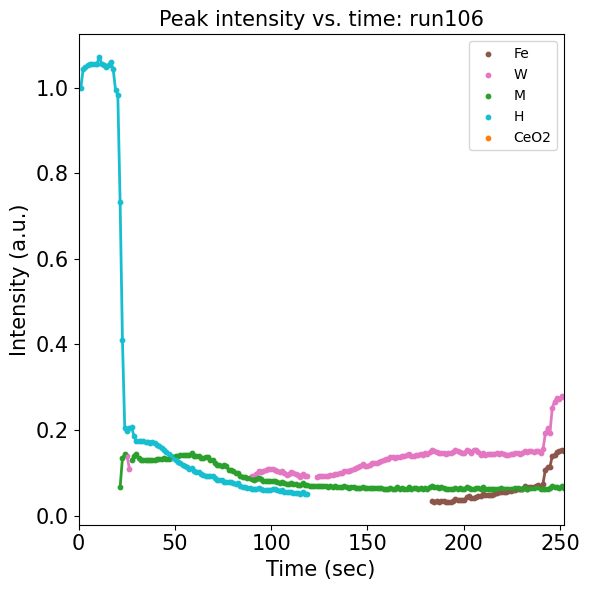

In [ ]:
#@title Intensity vs primary-# or time (don't edit unless necessary)

################ plotting selected timestamps and finding peaks
find_peak_outputs = []
for iv, timestamp in enumerate(timestamps):
    timestamp_num = int(timestamp.split('-')[-1]) # convert timestamp string to number
    filename = filedict[timestamp]
    '''
    print()
    print('Loading file', filename)
    '''
    ##print('Scan # ', timestamp_num)
    rawdata = np.loadtxt(filename)
    q = rawdata[:, 0]
    I = rawdata[:, 1]
    I = I - I.min() #"baselining" the data


    if timestamp == 'primary-1':
      print('This is the first file')
      #I0 = I
      I0 = I.copy() #fix I0!!!!!!!!!!!!!!!!!!!!!!!!!
      I_treated = I0/I0.max()
    # '''
    # if timestamp == 'primary-1': #for run 52, need to have 125 files
    #   print('This is the first file')
    #   I_treated = I/I.max()
    # elif timestamp == 'primary-2': #for run 52, need to have 125 files
    #   print('This is the second file')
    #   #I0 = I
    #   I0 = I.copy() #fix I0!!!!!!!!!!!!!!!!!!!!!!!!!
    #   I_treated = I0/I0.max()
    # '''
    else:
      #print('not the first file...')
      #I_treated = I/I0
      I_treated = I/I0.max()

    ####### find peaks ######################################################
    #scipy.signal.find_peaks(x, height=None, threshold=None, distance=None, prominence=None, width=None, wlen=None, rel_height=0.5, plateau_size=None)

    I_fe = I_treated[I_fe_low:I_fe_up] #define index of range within q to find peaks
    I_w = I_treated[I_w_low:I_w_up]
    I_m = I_treated[I_m_low:I_m_up]
    I_h = I_treated[I_h_low:I_h_up]
    I_ceo2 = I_treated[I_ceo2_low:I_ceo2_up]

    #num_phases = ['fe', 'w', 'm', 'h']
    num_phases = ['fe', 'w', 'm', 'h', 'ceo2']
    for iii in num_phases: #repeat this process for each phase
      #print('iii = ', iii)
      ############for iron#############################
      if iii == num_phases[0]: #iron
        peaks, properties = find_peaks(I_fe, prominence_fe)
        #print(peaks, properties)

        #print('Index of peak in x that satisfy all given conditions: ', peaks)
        #print('Peak height: ', properties['peak_heights'])

        if peaks.size > 0: #i.e. if the list isn't empty --> if a peak was found
          val1_fe = q[(I_fe_low + peaks)][0] #there should only be one peak identified by find_peaks if the proper range was selected, so selecting the first value of the array should really be the only value
          val2_fe = I_treated[(I_fe_low + peaks)][0]
          ##print('Fe peak is located at q = ', val1_fe, ' with I_treated = ', val2_fe)

        else:
          ##print('List is empty. No peaks found in the specified range')
          val1_fe = float('nan')
          #val2_fe = 0 #set intensity equal to zero if no peak is found
          val2_fe = float('nan')

      ############for hematite#############################
      if iii == num_phases[3]: #hematite
        peaks, properties = find_peaks(I_h, prominence_h)
        #print(peaks, properties)
        #print('Index of peak in x that satisfy all given conditions: ', peaks)
        #print('Peak height: ', properties['peak_heights'])

        if peaks.size > 0:
          val1_h = q[(I_h_low + peaks)][0]
          val2_h = I_treated[(I_h_low + peaks)][0]
          ##print('H peak is located at q = ', val1_h, ' with I_treated = ', val2_h)

        else:
          ##print('List is empty. No peaks found in the specified range')
          val1_h = float('nan')
          #val2_h = 0
          val2_h = float('nan')

      ############for wustite#############################
      if iii == num_phases[1]: #wustite
        peaks, properties = find_peaks(I_w, prominence_w)
        #print(peaks, properties)
        #print('Index of peak in x that satisfy all given conditions: ', peaks)
        #print('Peak height: ', properties['peak_heights'])

        if peaks.size > 0:
          val1_w = q[(I_w_low + peaks)][0]
          val2_w = I_treated[(I_w_low + peaks)][0]
          ##print('W peak is located at q = ', val1_w, ' with I_treated = ', val2_w)

        else:
          ##print('List is empty. No peaks found in the specified range')
          val1_w = float('nan')
          #val2_w = 0
          val2_w = float('nan')

      ############for magnetite#############################
      if iii == num_phases[2]: #magnetite
        peaks, properties = find_peaks(I_m, prominence_m)
        #print(peaks, properties)
        #print('Index of peak in x that satisfy all given conditions: ', peaks)
        #print('Peak height: ', properties['peak_heights'])

        if peaks.size > 0:
          val1_m = q[(I_m_low + peaks)][0]
          val2_m = I_treated[(I_m_low + peaks)][0]
          ##print('M peak is located at q = ', val1_m, ' with I_treated = ', val2_m)

        else:
          ##print('List is empty. No peaks found in the specified range')
          val1_m = float('nan')
          #val2_m = 0
          val2_m = float('nan')

      ############for ceo2 #############################
      if iii == num_phases[4]: #ceo2
        peaks, properties = find_peaks(I_ceo2, prominence_ceo2)
        #print(peaks, properties)
        #print('Index of peak in x that satisfy all given conditions: ', peaks)
        #print('Peak height: ', properties['peak_heights'])

        if peaks.size > 0:
          val1_ceo2 = q[(I_ceo2_low + peaks)][0]
          val2_ceo2 = I_treated[(I_ceo2_low + peaks)][0]
          ##print('ceo2 peak is located at q = ', val1_ceo2, ' with I_treated = ', val2_ceo2)

        else:
          ##print('List is empty. No peaks found in the specified range')
          val1_ceo2 = float('nan')
          #val2_ceo2 = 0
          val2_ceo2 = float('nan')


    #set the values here for this one timestamp
    item = {'Scan#': timestamp_num,
            'Fe': [val1_fe, val2_fe],
            'H': [val1_h, val2_h],
            'W': [val1_w, val2_w],
            'M': [val1_m, val2_m],
            'CeO2': [val1_ceo2, val2_ceo2]
            }
    find_peak_outputs.append(item)
    #print('find_peak_outputs = ', find_peak_outputs)



###### plotting results vs time ##################################################
x = []
y_fe = []
y_h = []
y_w = []
y_m = []
y_ceo2 = []
T_C = []
'''
print("find_peak_outputs = ", find_peak_outputs)
print('timestamps = ', timestamps)
print('ntimestamps = ', ntimestamps)
print()
'''
for i, timestamp in enumerate(timestamps):
  timestamp_num = int(timestamp.split('-')[-1]) # convert timestamp string to number
  #print('timestamp_num = ', timestamp_num)
  index_request = i
  #print('index is =', index_request)
  if index_request > ntimestamps: #once we've gone through the full list of timestamps, break the for loop
    break
  else:
    #print("find_peak_outputs[index_request]['Scan#'] = ", find_peak_outputs[index_request]['Scan#'])
    scan = find_peak_outputs[index_request]['Scan#']
    inten_fe = find_peak_outputs[index_request]['Fe'][1] #second value in the array gives intensity
    inten_h = find_peak_outputs[index_request]['H'][1]
    inten_w = find_peak_outputs[index_request]['W'][1]
    inten_m = find_peak_outputs[index_request]['M'][1]
    inten_ceo2 = find_peak_outputs[index_request]['CeO2'][1]
    x.append(scan)
    y_fe.append(inten_fe)
    y_h.append(inten_h)
    y_w.append(inten_w)
    y_m.append(inten_m)
    y_ceo2.append(inten_ceo2)

    pos_fe = find_peak_outputs[index_request]['Fe'][0] #for rough calculation of temperature
    pos_h = find_peak_outputs[index_request]['H'][0]
    pos_ceo2 = find_peak_outputs[index_request]['CeO2'][0]
    alpha = 11.8/1000000 #(13.5) https://www.sciencedirect.com/science/article/pii/0022459689901370, (11.8) https://www.sciencedirect.com/science/article/pii/S0254058499001091
    T_C.append(25 + (1/alpha)*(2.013/pos_ceo2 - 1))
    '''
    if np.isnan(pos_fe): #then use hematite's value
        #T_C.append(float('nan'))
        #T_C.append(25 + (1000000/14)*2*np.pi*(1/pos_h - 1/2.3135)) #alpha_L,hematite = 14x10-6 /C
        T_C.append(25 + (1000000/11)*2*np.pi*(1/pos_ceo2 - 1/2.013)) #alpha_L,ceo2 = 1.13×10−6 /C: https://ceramics.onlinelibrary.wiley.com/doi/am-pdf/10.1111/jace.16055
    else:
        #T_C.append(25 + (1000000/12.5)*2*np.pi*(1/pos_fe - 1/3.128))
        T_C.append(25 + (1000000/12)*2*np.pi*(1/pos_fe - 1/3.128)) #alpha_L,Fe = 12x10-6 /C
    '''
  #print()
print()
print('x = ', x)
print('y_fe = ', y_fe)
print('y_h = ', y_h)
print('y_w = ', y_w)
print('y_m = ', y_m)
print('y_ceo2 = ', y_ceo2)
print('T_C = ', T_C)

x=np.array(x) #convereting lists to arrays
y_fe=np.array(y_fe)
y_h=np.array(y_h)
y_w=np.array(y_w)
y_m=np.array(y_m)
y_ceo2=np.array(y_ceo2)
T_C=np.array(T_C)
print('Max T_C = ', np.nanmax(T_C))

####plotting peak intensity in terms of time, not scan #:
x_new = [i * frame_length for i in x]

thisfs = 15
markersz1 = 40

# axx.set_xlim(0, x.max())
# axx.scatter(x, y_fe, color = lincol_fe, marker='.', s=markersz1, label = 'Fe')
# axx.plot(x, y_fe, linewidth = lw, color = lincol_fe)
# axx.scatter(x, y_w, color = lincol_w, marker='.', s=markersz1, label = 'W')
# axx.plot(x, y_w, linewidth = lw, color = lincol_w)
# axx.scatter(x, y_m, color = lincol_m, marker='.', s=markersz1, label = 'M')
# axx.plot(x, y_m, linewidth = lw, color = lincol_m)
# axx.scatter(x, y_h, color = lincol_h, marker='.', s=markersz1, label = 'H')
# axx.plot(x, y_h, linewidth = lw, color = lincol_h)
# axx.scatter(x, y_ceo2, color = lincol_ceo2, marker='.', s=markersz1, label = 'CeO2')
# axx.plot(x, y_ceo2, linewidth = lw, color = lincol_ceo2)

fig, axx = plt.subplots(figsize=(6,6), tight_layout=True)
axx.set_xlim(0, (ntimestamps)*frame_length)
axx.scatter(x_new, y_fe, color = lincol_fe, marker='.', s=markersz1, label = 'Fe')
axx.plot(x_new, y_fe, linewidth = lw, color = lincol_fe)
axx.scatter(x_new, y_w, color = lincol_w, marker='.', s=markersz1, label = 'W')
axx.plot(x_new, y_w, linewidth = lw, color = lincol_w)
axx.scatter(x_new, y_m, color = lincol_m, marker='.', s=markersz1, label = 'M')
axx.plot(x_new, y_m, linewidth = lw, color = lincol_m)
axx.scatter(x_new, y_h, color = lincol_h, marker='.', s=markersz1, label = 'H')
axx.plot(x_new, y_h, linewidth = lw, color = lincol_h)
axx.scatter(x_new, y_ceo2, color = lincol_ceo2, marker='.', s=markersz1, label = 'CeO2')
axx.plot(x_new, y_ceo2, linewidth = lw, color = lincol_ceo2)




plt.legend(loc='upper right')
# axx.set_xlabel('Scan #', fontsize=thisfs)
axx.set_xlabel('Time (sec)', fontsize=thisfs)
axx.set_ylabel('Intensity (a.u.)', fontsize=thisfs)
axx.tick_params(axis='x', labelsize=thisfs)
axx.tick_params(axis='y', labelsize=thisfs)
plottit = 'Peak intensity vs. time: ' + run_folder.split('_')[0]
axx.set_title(plottit, fontsize=thisfs)
plt.show()
#be sure to check that the range, prominence, etc still work with a larger dataset of 125 timestamps


In [ ]:
print(I0.max())

2458.8543491363525


# OLD

path =  /content/drive/Shareddrives/leoradm_group/NSLS-II_202403/laser_programs_and_logs
fp = /content/drive/Shareddrives/leoradm_group/NSLS-II_202403/laser_programs_and_logs/LOG-Mar.28.2024-04.18.18_run51.csv
laser log sampling time:  2
no its not
no its not
no its not
no its not

recnum =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 1

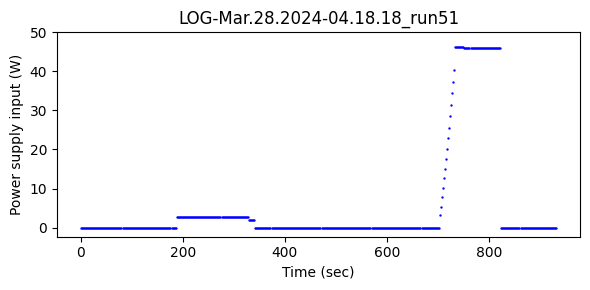

In [ ]:
#@title laser plots for March
index_start = 0
fn_laser = 'LOG-Mar.28.2024-04.18.18_run51'
userdir='/content/drive/Shareddrives/leoradm_group/NSLS-II_202403'
path = os.path.join(userdir, 'laser_programs_and_logs')
print('path = ',path)
fp = os.path.join(path, fn_laser + '.csv')
print('fp =', fp)

laser_log_data = []
with open(fp, mode = 'r') as file:
    csvFile = csv.DictReader(file)
    for lines in csvFile:
        #print(lines)
        laser_log_data.append(lines) #extract data from the file for python treatment

st = laser_log_data[2]['FileType:PSCS_Data_Log'].split(':')[-1]
st = st.replace('S', '') #sampling time
print('laser log sampling time: ',st)
t_laser_sampling = int(st)

lt = str(laser_log_data[1][None]) #laser log start time
lt = lt.replace("[' 2024", "")
lt = lt.replace(" PM']", "")
lt = lt.translate({ord(i): None for i in " "}) #strip any whitespace from the string
# print(lt)
# print(st)
#print('The log began recording at',lt,'and the sampling time is',st,'sec')

#print('\n here are the table headings: ', laser_log_data[3])

recnum = []
volt = []
current = []
count = 0
for lines in laser_log_data:
    if count >= 4:
        recnum.append(int(laser_log_data[count]['FileType:PSCS_Data_Log'].split(':')[-1]))
        volt.append(int(laser_log_data[count][None][0]) / 1000) #in V
        current.append(int(laser_log_data[count][None][1]) / 1000) #in A
    elif count < 4:
        print('no its not')
    count = count + 1
print()
print('recnum = ', recnum)
print('volt = ', volt)
print('current = ', current)

power = np.multiply(volt, current)

#a = recnum[index_start:index_start+ num_scans-1] #shifting the time data to match t=0 with the in-situ XRD
# #shifting the time data to match t=0 with the in-situ XRD
a = recnum
#print('a =', a)
x_axis_laser = [x - recnum[index_start] for x in a] #shift to match t=0 with XRD
x_axis_laser = [i * t_laser_sampling for i in x_axis_laser] #multiply by sampling rate to get real time
#y_axis_laser = power[index_start:index_start+ num_scans-1]
#y_axis_laser = power[index_start:index_start+ num_scans]
y_axis_laser = power
print('x_axis = ', x_axis_laser)


figsize = (6, 3)
fs = 18
fig, ax = plt.subplots(figsize=figsize, tight_layout=True)


#txt = 'The log began recording at ' + lt + ' with ' + st +' sec sampling \n t = 0 in the plot above is '+ t_xrd_start
#plt.scatter(recnum, power, marker = '.', s = markersz, c = 'b')
plt.scatter(x_axis_laser, y_axis_laser, marker = '.', s = markersz, c = 'b')
plt.ylabel("Power supply input (W)")
# plt.xlabel("Rec#")
plt.xlabel("Time (sec)")
plt.title(fn_laser)
#plt.figtext(0.5, -.125, txt, wrap=True, horizontalalignment='center', fontsize=10)
#ax.set_xticks([0, 20, 40, 60, 80, 100, 120, 140])
#ax.set_xlim(0, (num_scans-1)*frame_length)
#ax.set_xlim(0, (num_scans)*frame_length)
ax.set_yticks([0, 10, 20, 30, 40, 50])

##################################################################################


#plt.xlabel("Scan #")
plt.xlabel("Time (sec)")
#plt.title(fn_pyrom)

#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# ax.get_yticklabels()[1].set_color("gray") #changing the color for 248C
# ax.get_yticklabels()[5].set_color("gray") #changing the color for 1800C
plt.show()

##################################################################################

In [ ]:
#@title IGNORE (OUTDATED) Tracking peak position with time (multiple phases)
for run in ['run26']:
    ntimestamps = 125 ##########change later

    ###################### parsing the filename
    tiffdir = os.path.join(userdir, 'tiff_base')
    # print(userdir, tiffdir)
    runslist = glob.glob(tiffdir + '/*')
    # print(runslist)
    runsdict = {}
    for run_item in runslist:
        run_number = os.path.basename(run_item).split('_')[0]
        runsdict[run_number] = run_item
    # print(runsdict)

    file_pattern = os.path.join(runsdict[run], 'integration', '*_mean_q.chi')
    expname = os.path.basename(runsdict[run])
    # print(file_pattern)
    filelist = glob.glob(file_pattern)
    # print(filelist)
    filedict = {}
    for filename in filelist:
        file_parse = os.path.basename(filename).split('_')
        if not ('ss' in file_parse or 'stg2' in file_parse):
            file_number = file_parse[-3] # this takes the primary number
            filedict[file_number] = filename

    ################# grab ntimestamps curves (equally spacing in time)
    if get_timestamps:
        timestamps = ['primary-%d'%k for k in np.linspace(1, len(filedict)-1, ntimestamps).astype(int)]

    ################ plotting selected timestamps and finding peaks
    find_peak_outputs = []
    for iv, timestamp in enumerate(timestamps):
        timestamp_num = int(timestamp.split('-')[-1]) # convert timestamp string to number
        filename = filedict[timestamp]
        '''
        print()
        print('Loading file', filename)
        '''
        ##print('Scan # ', timestamp_num)
        rawdata = np.loadtxt(filename)
        q = rawdata[:, 0]
        I = rawdata[:, 1]
        I = I - I.min() #"baselining" the data
        #I = I - I[2350]
        '''
        #I = I + iv * 300
        #I = I + iv * 100 #iv is basically the index number for the scan. this makes a waterfall plot
        # I = I/I.max() + 0.25 * iv
        '''

        if timestamp == 'primary-1':
          print('This is the first file')
          #I0 = I
          I0 = I.copy() #fix I0!!!!!!!!!!!!!!!!!!!!!!!!!
          I_treated = I0/I0.max()
        # '''
        # if timestamp == 'primary-1': #for run 52, need to have 125 files
        #   print('This is the first file')
        #   I_treated = I/I.max()
        # elif timestamp == 'primary-2': #for run 52, need to have 125 files
        #   print('This is the second file')
        #   #I0 = I
        #   I0 = I.copy() #fix I0!!!!!!!!!!!!!!!!!!!!!!!!!
        #   I_treated = I0/I0.max()
        # '''
        else:
          #print('not the first file...')
          #I_treated = I/I0
          I_treated = I/I0.max()
          #I = I + iv * 5 #only for visualizing, not for peak finding

        ####### find peaks ######################################################
        #scipy.signal.find_peaks(x, height=None, threshold=None, distance=None, prominence=None, width=None, wlen=None, rel_height=0.5, plateau_size=None)
        I_fe = I_treated[I_fe_low:I_fe_up] #define index of range within q to find peaks
        I_w = I_treated[I_w_low:I_w_up]
        I_m = I_treated[I_m_low:I_m_up]
        I_h = I_treated[I_h_low:I_h_up]

        num_phases = ['fe', 'w', 'm', 'h']
        for iii in num_phases: #repeat this process for each phase
          #print('iii = ', iii)
          ############for iron#############################
          if iii == num_phases[0]: #iron
            peaks, properties = find_peaks(I_fe, prominence_fe)
            #print(peaks, properties)
            #print('Index of peak in x that satisfy all given conditions: ', peaks)
            #print('Peak height: ', properties['peak_heights'])

            if peaks.size > 0: #i.e. if the list isn't empty --> if a peak was found
              val1_fe = q[(I_fe_low + peaks)][0] #there should only be one peak identified by find_peaks if the proper range was selected, so selecting the first value of the array should really be the only value
              val2_fe = I_treated[(I_fe_low + peaks)][0]
              ##print('Fe peak is located at q = ', val1_fe, ' with I_treated = ', val2_fe)

            else:
              ##print('List is empty. No peaks found in the specified range')
              val1_fe = float('nan')
              #val2_fe = 0 #set intensity equal to zero if no peak is found
              val2_fe = float('nan')

          ############for hematite#############################
          if iii == num_phases[3]: #hematite
            peaks, properties = find_peaks(I_h, prominence_h)
            #print(peaks, properties)
            #print('Index of peak in x that satisfy all given conditions: ', peaks)
            #print('Peak height: ', properties['peak_heights'])

            if peaks.size > 0:
              val1_h = q[(I_h_low + peaks)][0]
              val2_h = I_treated[(I_h_low + peaks)][0]
              ##print('H peak is located at q = ', val1_h, ' with I_treated = ', val2_h)

            else:
              ##print('List is empty. No peaks found in the specified range')
              val1_h = float('nan')
              #val2_h = 0
              val2_h = float('nan')

          ############for wustite#############################
          if iii == num_phases[1]: #wustite
            peaks, properties = find_peaks(I_w, prominence_w)
            #print(peaks, properties)
            #print('Index of peak in x that satisfy all given conditions: ', peaks)
            #print('Peak height: ', properties['peak_heights'])

            if peaks.size > 0:
              val1_w = q[(I_w_low + peaks)][0]
              val2_w = I_treated[(I_w_low + peaks)][0]
              ##print('W peak is located at q = ', val1_w, ' with I_treated = ', val2_w)

            else:
              ##print('List is empty. No peaks found in the specified range')
              val1_w = float('nan')
              #val2_w = 0
              val2_w = float('nan')

          ############for magnetite#############################
          if iii == num_phases[2]: #magnetite
            peaks, properties = find_peaks(I_m, prominence_m)
            #print(peaks, properties)
            #print('Index of peak in x that satisfy all given conditions: ', peaks)
            #print('Peak height: ', properties['peak_heights'])

            if peaks.size > 0:
              val1_m = q[(I_m_low + peaks)][0]
              val2_m = I_treated[(I_m_low + peaks)][0]
              ##print('M peak is located at q = ', val1_m, ' with I_treated = ', val2_m)

            else:
              ##print('List is empty. No peaks found in the specified range')
              val1_m = float('nan')
              #val2_m = 0
              val2_m = float('nan')


        #set the values here for this one timestamp
        item = {'Scan#': timestamp_num,
                'Fe': [val1_fe, val2_fe],
                'H': [val1_h, val2_h],
                'W': [val1_w, val2_w],
                'M': [val1_m, val2_m]
                }
        find_peak_outputs.append(item)
        #print('find_peak_outputs = ', find_peak_outputs)
    #
        #ok, now plot the result of find_peaks for this run, to make sure  ################
        #would like to create a movie for each frame, displaying in the output window but without saving the movie
        ################Yifan pls help with implementing this

  ###### plot peak intensity vs time ##################################################
    x = []
    y_fe = []
    y_h = []
    y_w = []
    y_m = []
    '''
    print("find_peak_outputs = ", find_peak_outputs)
    print('timestamps = ', timestamps)
    print('ntimestamps = ', ntimestamps)
    print()
    '''
    for i, timestamp in enumerate(timestamps):
      timestamp_num = int(timestamp.split('-')[-1]) # convert timestamp string to number
      #print('timestamp_num = ', timestamp_num)
      index_request = i
      #print('index is =', index_request)
      if index_request > ntimestamps: #once we've gone through the full list of timestamps, break the for loop
        break
      else:
        #print("find_peak_outputs[index_request]['Scan#'] = ", find_peak_outputs[index_request]['Scan#'])
        scan = find_peak_outputs[index_request]['Scan#']
        inten_fe = find_peak_outputs[index_request]['Fe'][1] #second value in the array gives intensity
        inten_h = find_peak_outputs[index_request]['H'][1]
        inten_w = find_peak_outputs[index_request]['W'][1]
        inten_m = find_peak_outputs[index_request]['M'][1]
        x.append(scan)
        y_fe.append(inten_fe)
        y_h.append(inten_h)
        y_w.append(inten_w)
        y_m.append(inten_m)
      #print()
    print('x = ', x)
    print('y_fe = ', y_fe)
    print('y_h = ', y_h)
    print('y_w = ', y_w)
    print('y_m = ', y_m)

    ####to plot in terms of time, not scan #:
    #frame_rate = 1.2 #1.2 sec/frame
    frame_rate = 5 #1.2 sec/frame
    x_new = [i * frame_rate for i in x]

    thisfs = 15
    markersz = 7
    laserls = 'dotted'
    lasercol = 'tab:gray'
    fig, axx = plt.subplots(figsize=(6,6), tight_layout=True)
    axx.set_xlim(0, 124*1.2)
    axx.scatter(x_new, y_fe, color = lincol_fe, marker='.', s=markersz, label = 'Fe')
    axx.plot(x_new, y_fe, linewidth = lw, color = lincol_fe)
    axx.scatter(x_new, y_w, color = lincol_w, marker='.', s=markersz, label = 'W')
    axx.plot(x_new, y_w, linewidth = lw, color = lincol_w)
    axx.scatter(x_new, y_m, color = lincol_m, marker='.', s=markersz, label = 'M')
    axx.plot(x_new, y_m, linewidth = lw, color = lincol_m)
    axx.scatter(x_new, y_h, color = lincol_h, marker='.', s=markersz, label = 'H')
    axx.plot(x_new, y_h, linewidth = lw, color = lincol_h)

    ## manually mark when the laser turned on, reached max power, and turned off ##
    # for vi in laser:
    #   plt.axvline(x=vi, linestyle=laserls, color=lasercol)

    plt.legend(loc='upper right')
    # axx.set_xlabel('Scan #', fontsize=thisfs)
    axx.set_xlabel('Time (sec)', fontsize=thisfs)
    axx.set_ylabel('Intensity (a.u.)', fontsize=thisfs)
    plottit = 'Peak intensity vs. time: ' + expname.split('_')[0]
    axx.set_title(plottit, fontsize=thisfs)
    plt.show()
    #be sure to check that the range, prominence, etc still work with a larger dataset of 125 timestamps

In [ ]:
#@title Tracking peak position with time (one phase)
from scipy.signal import find_peaks
for run in ['run51']:
    ntimestamps = 5 ##########change later

    ###################### parsing the filename
    tiffdir = os.path.join(userdir, 'tiff_base')
    # print(userdir, tiffdir)
    runslist = glob.glob(tiffdir + '/*')
    # print(runslist)
    runsdict = {}
    for run_item in runslist:
        run_number = os.path.basename(run_item).split('_')[0]
        runsdict[run_number] = run_item
    # print(runsdict)

    file_pattern = os.path.join(runsdict[run], 'integration', '*_mean_q.chi')
    expname = os.path.basename(runsdict[run])
    # print(file_pattern)
    filelist = glob.glob(file_pattern)
    # print(filelist)
    filedict = {}
    for filename in filelist:
        file_parse = os.path.basename(filename).split('_')
        if not ('ss' in file_parse or 'stg2' in file_parse):
            file_number = file_parse[-3] # this takes the primary number
            filedict[file_number] = filename

    ################# grab ntimestamps curves (equally spacing in time)
    if get_timestamps:
        timestamps = ['primary-%d'%k for k in np.linspace(1, len(filedict)-1, ntimestamps).astype(int)]

    ################# plotting setting
    #figsize = (12, 6)
    figsize = (10, 6)
    fs = 18
    fig, ax = plt.subplots(figsize=figsize, tight_layout=True) #this is key for "hold on"!!!!

    num_of_lines = len(timestamps)
    lincol_gradient = iter(cm.copper(np.linspace(0,1,num_of_lines))) #Wistia, copper, and autumn are nice gradients
    counting = 0
    ################ plotting selected timestamps and finding peaks
    find_peak_outputs = []
    for iv, timestamp in enumerate(timestamps):
        timestamp_num = int(timestamp.split('-')[-1]) # convert timestamp string to number
        filename = filedict[timestamp]
        print()
        print('Loading file', filename)
        print('Scan # ', timestamp_num)
        rawdata = np.loadtxt(filename)
        q = rawdata[:, 0]
        I = rawdata[:, 1]
        I = I - I.min() #"baselining" the data
        #I = I - I[2350]
        '''
        #I = I + iv * 300
        #I = I + iv * 100 #iv is basically the index number for the scan. this makes a waterfall plot
        # I = I/I.max() + 0.25 * iv
        '''

        if timestamp == 'primary-1':
          print('This is the first file')
          #I0 = I
          I0 = I.copy() #fix I0!!!!!!!!!!!!!!!!!!!!!!!!!
          I_treated = I0/I0.max()
        else:
          #print('not the first file...')
          #I_treated = I/I0
          I_treated = I/I0.max()
          #I = I + iv * 5 #only for visualizing, not for peak finding

        ###### plot waterfall data ########################################
        c=next(lincol_gradient)
        #ax.plot(q, I, color = c, linewidth = lw)
        ax.plot(q, I_treated, color = c, linewidth = lw)
        ax.text(q[-1], I[-1], timestamp, ha='right', va='bottom')

        counting = counting + 1

        ####### find peaks ######################################################
        #find where the peak range should be, for given input index
        plt.axvline(x=q[880], linestyle='solid', linewidth = .1, color=lincol_fe)
        plt.axvline(x=q[915], linestyle='solid', linewidth = .1, color=lincol_fe)
        plt.axvline(x=q[1165], linestyle='solid', linewidth = .1, color=lincol_w)
        plt.axvline(x=q[1200], linestyle='solid', linewidth = .1, color=lincol_w)
        plt.axvline(x=q[590], linestyle='solid', linewidth = .1, color=lincol_m)
        plt.axvline(x=q[625], linestyle='solid', linewidth = .1, color=lincol_m)
        plt.axvline(x=q[660], linestyle='solid', linewidth = .1, color=lincol_h)
        plt.axvline(x=q[680], linestyle='solid', linewidth = .1, color=lincol_h)

        #find peaks
        #scipy.signal.find_peaks(x, height=None, threshold=None, distance=None, prominence=None, width=None, wlen=None, rel_height=0.5, plateau_size=None)

        #range and prominence for peak finding
        I_fe_low = 880
        I_fe_up = 915
        #prominence_fe = 1.5
        #prominence_fe = .1
        prominence_fe = .075
        I_w_low = 1165
        I_w_up = 1200
        I_m_low = 590
        I_m_up = 625
        I_h_low = 660
        I_h_up = 680
        prominence_h = .075

        I_fe = I_treated[I_fe_low:I_fe_up] #define index of range within q to find peaks
        I_w = I_treated[I_w_low:I_w_up]
        I_m = I_treated[I_m_low:I_m_up]
        I_h = I_treated[I_h_low:I_h_up]


        peaks, properties = find_peaks(I_fe, prominence_fe)
        #print(peaks, properties)
        #print('Index of peak in x that satisfy all given conditions: ', peaks)
        #print('Peak height: ', properties['peak_heights'])

        if peaks.size > 0: #i.e. if the list isn't empty --> if a peak was found
          val1 = q[(I_fe_low + peaks)][0] #there should only be one peak identified by find_peaks if the proper range was selected, so selecting the first value of the array should really be the only value
          val2 = I_treated[(I_fe_low + peaks)][0]
          print('Fe peak is located at q = ', val1, ' with I_treated = ', val2)
          item = {
          'Scan#': timestamp_num,
          'Fe': [val1, val2]
          }
          find_peak_outputs.append(item)

        else:
          print('List is empty. No peaks found in the specified range')
          item = {
          'Scan#': timestamp_num,
          'Fe': [float('nan'), 0] #, #set intensity equal to zero if no peak is found
          }
          find_peak_outputs.append(item)
        #print('find_peak_outputs = ', find_peak_outputs)

    ######### load multiple reference files, Yifan, 2024/4/12
    ref_phases = ['Iron_2300200_q', 'Wuestite_9009766_q','Lab_magnetite_q','Lab_hematite_q','67p_Fe_ore_q']
    color_ref_phases = [lincol_fe, lincol_w, lincol_m, lincol_h, lincol_h_ore]
    ref_shift_y = -1
    for i_phase, ref_phase in enumerate(ref_phases):
        reffile = os.path.join(userdir, 'userScripts', 'xrd_profiles', ref_phase + '.txt')
        refdata = np.loadtxt(reffile)
        q_ref = refdata[:, 0]
        I_ref = refdata[:, 1]
        I_ref = I_ref - I_ref.min() #"baselining" the data
        sensitivity = 500 #the larger the value, the more prominent the peaks
        #I_ref = I_ref/(I_ref.max()/sensitivity)  + ref_shift_y*(i_phase + 1) -200
        I_ref = I_ref/(I0.max())  + ref_shift_y*(i_phase + 1) -5
        ax.plot(q_ref, I_ref, label= ref_phase, linewidth= lw, color= color_ref_phases[i_phase])


    xlim_left, xlim_right = -0.25, 10.5 #for q
    ax.set_xlim(xlim_left, xlim_right)
    ######## put the legend outside of the box, Yifan, 20240422 ############
    # ax.legend(loc='lower right')
    ax.legend(loc='center left', bbox_to_anchor=[1, 0.5])
    ########################################################################

    ax.set_xlabel(r'$q  ({\AA}^{-1})$', fontsize=fs)
    ax.set_ylabel(r'$I$', fontsize=fs)
    ax.set_title(expname, fontsize=fs)
    ax.tick_params(labelsize=fs)
    #ax.set_yticklabels([]) #turns off tick labels for vertical axis

################# plot vertical lines for the reference phase peaks

    for i_vert_line in ref_q_fe: #plot the vertical lines
        plt.axvline(x=i_vert_line, linestyle='dotted', color=lincol_fe)

    for i_vert_line in ref_q_w:
            plt.axvline(x=i_vert_line, linestyle='dotted', color=lincol_w)

    for i_vert_line in ref_q_m:
            plt.axvline(x=i_vert_line, linestyle='dotted', color=lincol_m)

    for i_vert_line in ref_q_h:
            plt.axvline(x=i_vert_line, linestyle='dotted', color=lincol_h)

 ########## save settings
    if response == "y":
      print("Saving the file...!")
      fname_typ = 'wf_'+ xrd_type + '_' + expname + '.png' #wf = waterfall
      save_loc = os.path.join(userdir, 'userAnalysis' + '/' + 'waterfallPlots'+ '/')
      if not os.path.isdir(save_loc):
          os.makedirs(save_loc)
      plt.savefig(save_loc + fname_typ)
    elif response == "n":
      print()
      print("Showing the plot without saving...")
      plt.show()
    else:
      print()
      print("Please enter yes or no.")

  ######plot the time data
    x = []
    y = []
    '''
    print("find_peak_outputs = ", find_peak_outputs)
    print('timestamps = ', timestamps)
    print('ntimestamps = ', ntimestamps)
    print()
    '''
    for i, timestamp in enumerate(timestamps):
      timestamp_num = int(timestamp.split('-')[-1]) # convert timestamp string to number
      #print('timestamp_num = ', timestamp_num)
      index_request = i
      #print('index is =', index_request)
      if index_request > ntimestamps: #once we've gone through the full list of timestamps, break the for loop
        break
      else:
        #print("find_peak_outputs[index_request]['Scan#'] = ", find_peak_outputs[index_request]['Scan#'])
        scan = find_peak_outputs[index_request]['Scan#']
        inten = find_peak_outputs[index_request]['Fe'][1] #second value in the array gives intensity
        x.append(scan)
        y.append(inten)
      #print()
    print('x = ', x)
    print('y = ', y)

    thisfs = 15
    fig, axx = plt.subplots(figsize=(6,6), tight_layout=True)
    axx.scatter(x, y, color = lincol_fe, marker='.', s=5)
    axx.plot(x, y, linewidth = lw, color = lincol_fe)
    axx.set_xlabel('Scan #', fontsize=thisfs)
    axx.set_ylabel('Intensity (a.u.)', fontsize=thisfs)
    plottit = 'Fe formation with time: ' + expname.split('_')[0]
    axx.set_title(plottit, fontsize=thisfs)
    plt.show()
      #check that the range, prominence, etc still work with a larger dataset of 125 timestamps

In [ ]:
#@title Loading the files: depth scans only (OLD -- this still required "run#" as an input, rather than a common file name)
ntimestamps = 20 ##########change later
#give the waterfall plot for in-situ series or depth series?
data_series_type = ['in-situ','depth'] #0 or 1
response = data_series_type[1]
print('response =', response)

run_folder = 'run106_hematite_H2_blue_lowPower' #in which "run" folder is the data located?
run_path = os.path.join(userdir, 'tiff_base', run_folder, 'integration')
print('run_path = ', run_path)

#which files to read?
#file name example: run106_hematite_H2_blue_lowPower_20240623-204534_b2a369_ss_stg2_y_40,95mm_primary-1_mean_q
run = 'run106'
###################### parsing the filename
tiffdir = os.path.join(userdir, 'tiff_base')
#print('userdir = ', userdir, 'tiffdif = ', tiffdir)
runslist = glob.glob(tiffdir + '/*')
#print('runslist = ', runslist)

runsdict = {}
for run_item in runslist:
    run_number = os.path.basename(run_item).split('_')[0]
    runsdict[run_number] = run_item
print('runsdict = ', runsdict)

file_pattern = os.path.join(runsdict[run], 'integration', '*_mean_q.chi')
expname = os.path.basename(runsdict[run])
# print(file_pattern)
filelist = glob.glob(file_pattern)
# print(filelist)
filedict = {}
for filename in filelist:
    file_parse = os.path.basename(filename).split('_')
    # print('basename is: ', os.path.basename(filename)) #this gives the file name without the path leading up to this file
    # print('split is: ', os.path.basename(filename).split('_'))

    if not ('tth' in file_parse):
        # if not ('ss' in file_parse or 'stg2' in file_parse): ###
        #     print('this should not be a depth scan')
        if ('ss' in file_parse or 'stg2' in file_parse): ###
            #print('this should be a depth scan')
            file_number = file_parse[-3] # this gives "primary-#"
            #print(file_number)
            filedict[file_number] = filename

print(filedict)

################# grab ntimestamps curves (equally spacing in time)
if get_timestamps:
    #timestamps = ['primary-%d'%k for k in np.linspace(1, len(filedict)-1, ntimestamps).astype(int)] #this prepares the list of files to plot in chronological order
    timestamps = ['primary-%d'%k for k in np.linspace(1, len(filedict), ntimestamps).astype(int)] #this organizes the list in chronological order ##@Yifan, shouldn't this be the correct line?
print(timestamps)

raw_data_save_all = []
save_depth = []
#save_time_insitu = []

print('ntimestamps =', ntimestamps)
for iv, timestamp in enumerate(timestamps): #this section loads the selected files in chronological order, into the array raw_data_save_all
    timestamp_num = int(timestamp.split('-')[-1]) # convert timestamp string to number
    filename = filedict[timestamp]
    # print()
    #print('Loading file...', os.path.basename(filename))
    #print('Scan # ', timestamp_num)
    rawdata = np.loadtxt(filename) #each rawdata is [(#data, 2)], where 2 represents q and I columns. q = rawdata[:, 0], I = rawdata[:, 1]
    raw_data_save_all.append(rawdata) #stacks the array  #makes 3D array of 125, q and I for each run --> (nstimestamps, nt, 2)
    if response == 'depth':
        save_depth.append([timestamp_num, os.path.basename(filename).split('_')[-4]])

##### convert raw data_save_all into numpy array ######
raw_data_save_all = np.array(raw_data_save_all)
print('shape of array is: ', raw_data_save_all.shape)

#print(save_depth)
save_depth = np.array(save_depth)
#print(save_depth)
print(save_depth.shape)

response = depth
run_path =  /content/drive/Shareddrives/leoradm_group/NSLS-II_202406/tiff_base/run106_hematite_H2_blue_lowPower/integration
runsdict =  {'run13': '/content/drive/Shareddrives/leoradm_group/NSLS-II_202406/tiff_base/run13_MgO_hematite_v2_repeat', 'run12': '/content/drive/Shareddrives/leoradm_group/NSLS-II_202406/tiff_base/run12_MgO_hematite_v2', 'run8': '/content/drive/Shareddrives/leoradm_group/NSLS-II_202406/tiff_base/run8_MgO_reference', 'run9': '/content/drive/Shareddrives/leoradm_group/NSLS-II_202406/tiff_base/run9_CaO_reference', 'run10': '/content/drive/Shareddrives/leoradm_group/NSLS-II_202406/tiff_base/run10_SiO2_reference', 'run11': '/content/drive/Shareddrives/leoradm_group/NSLS-II_202406/tiff_base/run11_cuvette_reference', 'run25': '/content/drive/Shareddrives/leoradm_group/NSLS-II_202406/tiff_base/run25_ore_Tcalib', 'dummy2': '/content/drive/Shareddrives/leoradm_group/NSLS-II_202406/tiff_base/dummy2', 'CeO2': '/content/drive/Shareddrives/leoradm_group/NSLS-I

In [ ]:
from time import localtime, strftime
#from time import gmtime, strftime
now = strftime("%Y-%m-%d_%H%M%S", localtime()) #note: this is expressed in UTC time
print(now)

#print(raw_data_save_all[174])
#print(raw_data_save_all.shape[0])

2024-08-08_192942


run_folder = run126_references
run_path =  /content/drive/Shareddrives/leoradm_group/NSLS-II_202406/tiff_base/run126_references/integration
file_path = /content/drive/Shareddrives/leoradm_group/NSLS-II_202406/tiff_base/run126_references/integration/run126_references_20240624-071605_450af9_primary-1_mean_q.chi
rawdata has been loaded
I.max() = 171.56674194335938


(-0.25, 11.0)

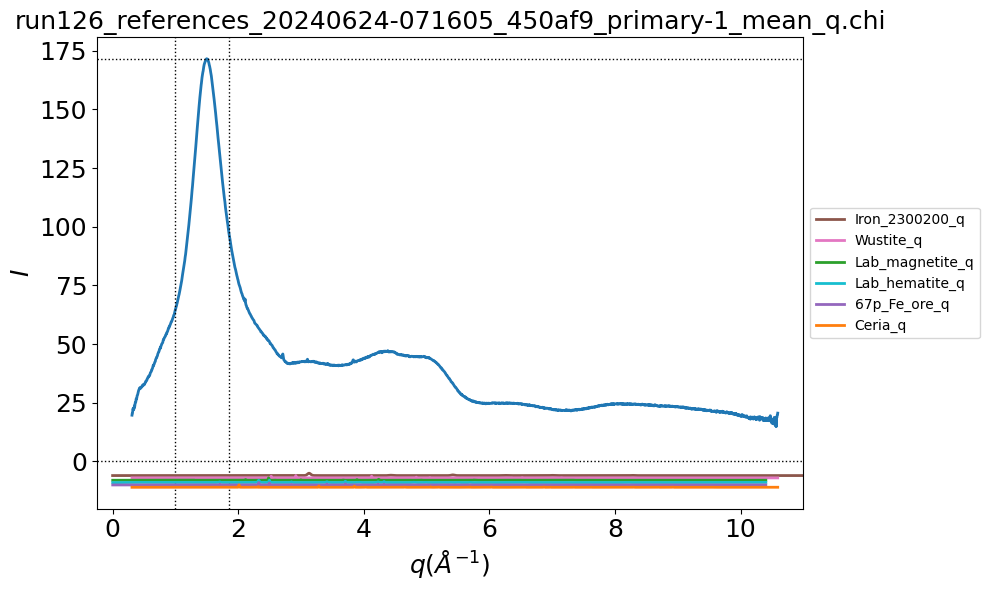

In [ ]:
#@title (OLD) Load and plot one scan
file_name = 'run126_references_20240624-071605_450af9_primary-1_mean_q.chi'
run_folder = foldername(file_name)
results = get_rawdata(run_folder, file_name)
q = results[:, 0]
I = results[:, 1]

## create figure object -- plotting setting ##
#figsize = (12, 6)
figsize = (10, 6)
fs = 18
fig, ax = plt.subplots(figsize=figsize, tight_layout=True)

ax.set_xlabel(r'$q  ({\AA}^{-1})$', fontsize=fs)
ax.set_ylabel(r'$I$', fontsize=fs)
ax.set_title(file_name, fontsize=fs)
ax.tick_params(labelsize=fs)

#ax.plot(q, I/I.max(), linewidth = lw)
ax.plot(q, I, linewidth = lw)
print('I.max() =',I.max())
lw_fp=1

ax.axhline(y=0, linestyle='dotted', linewidth = lw_fp, color='k')
ax.axhline(y=I.max(), linestyle='dotted', linewidth = lw_fp, color='k')
#plot_vert_refs()
ax.axvline(x=q[200], linestyle='dotted', linewidth = lw_fp, color='k')
ax.axvline(x=q[450], linestyle='dotted', linewidth = lw_fp, color='k')

plot_mult_refs()

ax.legend(loc='center left', bbox_to_anchor=[1, 0.5])
ax.set_xlim([-.25,11])
#ax.set_ylim([-12,1])


fig, ax = plt.subplots(2, figsize=figsize, tight_layout=True)
ax[1].set_xlabel(r'$q  ({\AA}^{-1})$', fontsize=fs)
ax[1].set_yticks([])
ax[1].tick_params(labelsize=fs)
ax[1].set_xlim([-.25,11])

ax[1].plot(q_ref, I_ref, label= ref_phase, linewidth= lw, color= color_ref_phases[i_phase])

ax[0].set_title(run_folder +'_frame#' + str(frame), fontsize=fs)
ax[0].set_xlim([-.25,11])
ax[0].set_xticks([])
ax[0].set_ylim([-.25,Imax])
ax[0].set_ylabel(r'$I$', fontsize=fs)
ax[0].tick_params(labelsize=fs)
my_data = ax[0].plot(q, I, linewidth = lw,color='tab:gray')

number of pyrometer data points (num_scans) =  210
path =  /content/drive/Shareddrives/leoradm_group/NSLS-II_202406/june_laser_programs_and_logs
fp = /content/drive/Shareddrives/leoradm_group/NSLS-II_202406/june_laser_programs_and_logs/LOG-Jun.23.2024-09.03.25-run106.csv
laser log sampling time:  1
no its not
no its not
no its not
no its not

recnum =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150,

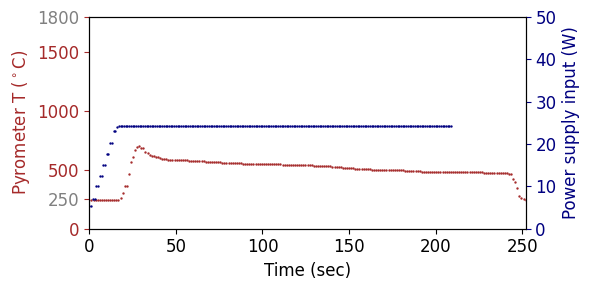

In [ ]:
#@title OLD Combined pyrometer and laser plots (don't edit unless necessary)
num_scans = len(filedict) #number of scans (used in this section to link to scan/rec# to time)
print('number of pyrometer data points (num_scans) = ', num_scans)

######################### laser log ###########################################
path = os.path.join(userdir, 'june_laser_programs_and_logs')
print('path = ',path)
fp = os.path.join(path, fn_laser + '.csv')
print('fp =', fp)

laser_log_data = []
with open(fp, mode = 'r') as file:
    csvFile = csv.DictReader(file)
    for lines in csvFile:
        #print(lines)
        laser_log_data.append(lines) #extract data from the file for python treatment

st = laser_log_data[2]['FileType:PSCS_Data_Log'].split(':')[-1]
st = st.replace('S', '') #sampling time
print('laser log sampling time: ',st)

lt = str(laser_log_data[1][None]) #laser log start time
lt = lt.replace("[' 2024", "")
lt = lt.replace(" PM']", "")
lt = lt.translate({ord(i): None for i in " "}) #strip any whitespace from the string
# print(lt)
# print(st)
#print('The log began recording at',lt,'and the sampling time is',st,'sec')

#print('\n here are the table headings: ', laser_log_data[3])

recnum = []
volt = []
current = []
count = 0
for lines in laser_log_data:
    if count >= 4:
        recnum.append(int(laser_log_data[count]['FileType:PSCS_Data_Log'].split(':')[-1]))
        volt.append(int(laser_log_data[count][None][0]) / 1000) #in V
        current.append(int(laser_log_data[count][None][1]) / 1000) #in A
    elif count < 4:
        print('no its not')
    count = count + 1
print()
print('recnum = ', recnum)
print('volt = ', volt)
print('current = ', current)

power = np.multiply(volt, current)

#a = recnum[index_start:index_start+ num_scans-1] #shifting the time data to match t=0 with the in-situ XRD
a = recnum[index_start:index_start+ num_scans] #shifting the time data to match t=0 with the in-situ XRD
#print('a =', a)
x_axis_laser = [x - recnum[index_start] for x in a] #shift to match t=0 with XRD
x_axis_laser = [i * t_laser_sampling for i in x_axis_laser] #multiply by sampling rate to get real time
#y_axis_laser = power[index_start:index_start+ num_scans-1]
y_axis_laser = power[index_start:index_start+ num_scans]
print('x_axis = ', x_axis_laser)
##################################################################################

#################### Plotting the pyrometer data: T vs scan #, 5/16/24 ##########
path = os.path.join(userdir, 'tiff_base')
fp = os.path.join(path, fn_pyrom + '.xlsx')
pyrom_data = pd.read_excel(fp)
x_axis_pyrom = pyrom_data['seq_num']
x_axis_pyrom_new = [i * frame_length for i in x_axis_pyrom]
y_axis_pyrom = pyrom_data['eurotherm_temperature']

##################################################################################

########### combined plot pyrometer vs laser ####################
figsize = (6, 3)
fs = 12
col_pyrom = 'brown'
col_laser = 'navy'

fig, ax1 = plt.subplots(figsize=figsize, tight_layout=True)
ax2 = ax1.twinx()
#ax1.set_xticks([0, 20, 40, 60, 80, 100, 120, 140])
ax1.set_xlim(0, (num_scans)*frame_length)

ax1.scatter(x_axis_pyrom_new, y_axis_pyrom, marker = '.', s = markersz, c = col_pyrom)
ax2.scatter(x_axis_laser, y_axis_laser, marker = '.', s = markersz, c = col_laser)

ax1.set_xlabel("Time (sec)", fontsize=fs)
ax1.tick_params(axis='x', labelsize=fs)

ax1.set_ylabel("Pyrometer T ($^\circ$C)", fontsize=fs, color=col_pyrom)
ax1.tick_params(axis='y', colors=col_pyrom, labelsize=fs)
ax1.set_ylim(0, 1800)
ax1.set_yticks([0, 250, 500, 1000, 1500, 1800])
ax1.get_yticklabels()[1].set_color("gray") #changing the color for 248C
ax1.get_yticklabels()[5].set_color("gray") #changing the color for 1800C

ax2.set_ylabel('Power supply input (W)', fontsize=fs, color=col_laser)
ax2.tick_params(axis='y', colors=col_laser, labelsize=fs)
ax2.set_yticks([0, 10, 20, 30, 40, 50])

plt.show()
